# **多元卡尔曼滤波器**

过滤多个随机变量

In [1]:
%matplotlib inline

#format the book
import lean.book_format as book_format
book_format.set_style()

## **一、介绍**

我们现在准备研究和实现完整的多元形式的卡尔曼滤波器。在上一章中，我们学会了如何用多元高斯表达多个随机变量之间的相关性，例如飞机的位置和速度。我们也了解了变量之间的相关性如何显著的改变后验估计。如果我们只是粗略知道飞机的位置和速度，但是它们是相关的，那么我们新的估计值是可以非常准确的。

我更喜欢通过几个工作示例让你对滤波器原理产生直觉感受。我将会掩盖很多不必要的问题。我向您展示的某些内容仅适用于特殊情况，而其他内容则“神奇”-不清楚我是如何得出某个结果的。如果我从严格的、广义的方程开始，你会对所有这些术语的含义以及如何将它们应用于你的问题感到挠头。在后面的章节中，我将提供一个更严格的数学基础，届时我将不得不纠正我在本章中所做的近似值，或者提供我在这里没有涉及的其他信息。

为了实现这一目标，我们将自己限制在可以用牛顿运动方程描述的问题子集上。这些滤波器称为离散化连续时间运动滤波器。在卡尔曼滤波数学一章中，我们将开发非牛顿系统的数学。

## **二、牛顿运动方程**

牛顿的运动方程告诉我们，给定一个系统的恒定速度 𝑣 ，我们可以计算出它在时间 𝑡 后的位置 𝑥 ：

$$x = vt + x_0$$

例如，如果我们从位置 13 开始，我们的速度是 10 m/s，我们行进 12 秒，我们的最终位置是 133（ 10×12+13 ）。

我们可以将恒定加速度与这个方程结合起来

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

如果我们假设恒定的加加速度，我们会得到

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

这些方程是通过微积分方程生成的。给定一个恒定的速度 v，我们可以用方程计算随时间推移的行进距离

$$x = vt + x_0$$

我们可以推导出来

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$

当您设计卡尔曼滤波器时，您首先要从描述系统动力学的微分方程组开始。大多数微分方程组不容易以这种方式积分。我们从牛顿方程开始，因为我们可以积分并获得闭式解，这使得卡尔曼滤波器更容易设计。另一个好处是牛顿方程是用于跟踪移动物体的正确方程，这是卡尔曼滤波器的主要用途之一。

## **三、卡尔曼滤波算法**

该算法与我们每章中使用的贝叶斯滤波算法相同。更新步骤稍微复杂一些，但当我们开始接触它时，我会解释原因。

初始化

- 1. 初始化滤波器状态(初始化状态变量)
- 2. 初始化状态变量的信念(协方差矩阵)

预测

- 1. 使用过程模型去预测下一个时间步的状态(获得先验估计值)
- 2. 调整信念以解释预测中的不确定性(先验估计的协方差矩阵)

更新

- 1. 获取测量值以及与准确性相关的信念(传感器的测量方差)
- 2. 计算测量值与先验估计的残差
- 3. 根据测量和先验估计的信念，计算卡尔曼增益系数
- 4. 根据卡尔曼增益设置新的状态(后验估计值)
- 5. 根据测量的确定性，更新状态的信念(后验估计的协方差)

提醒一下，以下是该算法的图形描述：

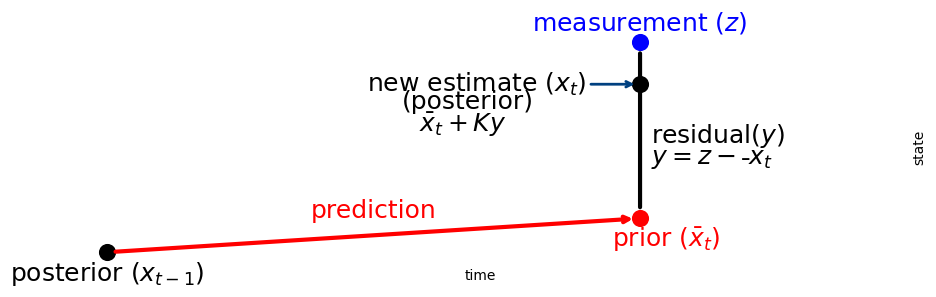

In [2]:
import lean.kf_book.book_plots as book_plots
book_plots.show_residual_chart()

单变量卡尔曼滤波器用单变量高斯表示状态。当然，多元卡尔曼滤波器将使用多元高斯滤波器来表示状态。我们在上一章中了解到，多元高斯使用向量表示均值，矩阵表示协方差。这意味着卡尔曼滤波器需要使用线性代数来执行估计。

我不希望你记住这些方程，但我在下面列出了单变量和多变量方程。它们非常相似。

<u>**预测**</u>

$\begin{array}{|l|l|l|}
\hline
\text{单变量} & \text{单变量} & \text{多元}\\
& \text{(卡尔曼形式)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

不用担心线性代数的细节，我们可以看到：

$\mathbf x,\, \mathbf P$ 是状态的均值和协方差。 它们对应于 $x$ and $\sigma^2$.

$\mathbf F$ 是 *状态转移矩阵*. 当与 $\bf x$ 相乘，它计算得到先验。

$\mathbf Q$ 过程模型的协方差矩阵. 它对应于 $\sigma^2_{f_x}$。

$\mathbf B$ and $\mathbf u$ 对我们来说是新的. 它允许我们对系统的控制输入进行建模。


<u>**更新**</u>

$\begin{array}{|l|l|l|}
\hline
\text{单变量} & \text{单变量} & \text{多元}\\
& \text{(卡尔曼形式)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ 是测量函数. 我们在本书中还没有见到过它，我会稍后解释它。如果你想象一下把 $\mathbf H$ f从方程中删除, 你应该能够看到这些方程也是相似的。

$\mathbf z,\, \mathbf R$ 是测量的均值和噪声协方差. 在单变量滤波器中，它对应单变量的 $z$ and $\sigma_z^2$ 。(我已经用 $x$ 代替了单变量方程的 $\mu$，以使符号尽可能相似)。

$\mathbf y$ and $\mathbf K$ 是残差和卡尔曼增益。

细节将会与单变量滤波器不同，因为它们是向量和矩阵。但是概念完全相同。

- 使用高斯来表示我们的状态的估计和误差
- 使用高斯来表示测量值和它的误差
- 使用高斯去表示过程模型
- 使用过程模型去预测下一个时间步的状态(先验估计)
- 根据测量和先验估计形成后验估计

作为设计师，你的工作是设计状态 $\left(\mathbf x, \mathbf P\right)$, 过程 $\left(\mathbf F, \mathbf Q\right)$, 测量 $\left(\mathbf z, \mathbf R\right)$, 和测量函数 $\mathbf H$. 如果系统有控制输入，比如机器人，你也将会设计 $\mathbf B$ and $\mathbf u$.

我已经将卡尔曼滤波器的方程编程为 predict 和 update 函数在FilterPy 模块中。您将使用以下命令导入它们：

```python
from filterpy.kalman import predict, update
```

### **跟踪狗**

让我们回到我们老生常谈的追踪狗的问题。这次我们将包括上一章的基本见解，并使用隐藏变量来改进我们的估计。我可以从数学开始，但让我们实现一个过滤器，边走边学。从表面上看，数学是不同的，也许比前几章更复杂，但想法都是一样的——我们只是多元高斯的乘法和加法。

我们首先编写一个狗的运动仿真。这个仿真将会运行count个步骤，在每个时间步中，它向前移动接近1m。在每个步骤中，速度将会根据过程方差process_var而变化。更新位置之后，我们获取一个测量值，假设传感器的方差是z_var。该函数返回一个numpy数组，一个是位置(先验)，一个是测量值。

In [3]:
import math
import numpy as np
from numpy.random import randn

# 模拟狗的运动和传感器测量
def compute_dog_data(z_var, process_var, count=1, dt=1.0):
    x, vel = 0.0, 1.0                               # 狗的初始位置和速度
    z_std = math.sqrt(z_var)                        # 传感器测量的标准差
    p_std = math.sqrt(process_var)                  # 过程模型的标准差
    
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)                 # 每个时刻的实际速度
        x += v * dt                                 # 每个时刻的实际位置
        
        xs.append(x)                                # 过程模型预测的狗的位置，先验估计
        zs.append(x + randn() * z_std)              # 传感器测量的狗的位置，证据或者可能性
        
    return np.array(xs), np.array(zs)

### **预测步骤**

对于预测，我们需要设计状态变量和它的协方差、过程模型和过程噪声，以及可选的控制输入。我们会按顺序处理它们。

#### **设计状态变量**

我们之前使用高斯在一个维度上跟踪狗的位置。均值 $(\mu)$表示最有可能的位置，方差($\sigma^2$)表示位置的概率分布。位置是系统的状态，我们称$\mu$ 为 *状态变量*。

在这个问题中，我们将跟踪狗的位置和速度。这要求我们去使用由状态向量$\mathbf x$以及相应的协方差矩阵$\mathbf P$表示的多元高斯。

状态变量要么是*观察变量*-由传感器直接测量，要么是由观察变量推断的*隐藏变量*。对于我们狗的跟踪问题，传感器仅仅测量位置信息，因此位置是观察变量、速度是隐藏变量。我们将很快学习如何跟踪隐藏变量。

重要的是要了解跟踪位置和速度是一种设计选择，其含义和假设我们尚未准备好探索。例如，我们还可以跟踪加速度，甚至是颠簸。现在，回想一下，在上一章中，我们展示了在协方差矩阵中包含速度会导致位置方差小得多。我们将在本章后面学习卡尔曼滤波器如何计算隐藏变量的估计值。

在单变量章节中，我们用标量值表示狗的位置（例如 $\mu=3.27$）。在上一章中，我们学习了对多个变量使用多元高斯。例如，如果我们想指定 10.0 m 的位置和 4.5 m/s 的速度，我们可以这样写：

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

卡尔曼滤波器是使用线性代数实现的。我们使用$n\times 1$的矩阵(称为一个*向量*)去存储$n$ 个状态变量。对于狗跟踪问题，我们使用 $x$ 表示位置，使用 $x$ 的一阶导数 $\dot x$ 表示速度。我使用牛顿的点符号来表示导数;$\dot x$ 表示 x 相对于 t 的一阶导数：$\dot x = \frac{dx}{dt}$。卡尔曼滤波方程使用 $\mathbf x$ 作为状态，因此我们将 $\mathbf x$ 定义为：

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

我们使用 $\mathbf x$ 而不是 $\mu$，但要认识到这是多元高斯的平均值。

另一种写法是$\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$，因为行向量的转置是列向量。这种表示法在文本中更易于使用，因为它占用的垂直空间更小。

$\mathbf x$ 和位置 $x$ 巧合的具有相同的名称。如果我们在y轴方向对狗进行跟踪，我们会写 $\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$, 而不是  $\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ 在卡尔曼滤波器文献中是一个标准的状态变量名称。并且，我们不会改变它以赋予它更有意义的名称。这种命名的一致性有利于与同行之间的交流。

让我们对此进行编码，初始化 `x`非常简单。

In [4]:
# 狗的初始位置和速度
x = np.array([[10.0],
              [4.50]])
x

array([[10. ],
       [ 4.5]])

我经常在代码中使用转置将行矩阵转换为列向量，因为我发现输入和阅读更容易：

In [5]:
x = np.array([[10.0, 4.50]]).T
x

array([[10. ],
       [ 4.5]])

但是，NumPy 将 1D 数组识别为向量(列向量)，因此我可以使用 1D 数组简化此行。

In [6]:
x = np.array([10.0, 4.50])
x, x.shape

(array([10. ,  4.5]), (2,))

所有数组的元素具有相同的数据类型，通常是float和int类型。如果列表中所有元素的类型都是int，那么创建的array的数据类型也是int，否则的话，它将是float类型的数组。我经常为了方便会指定一个数字为浮点型。

In [7]:
np.array([1.0, 0, 0, 0, 0, 0])

array([1., 0., 0., 0., 0., 0.])

以下是一些示例。

In [8]:
A = np.array([[1, 2], [3, 4]])          # 维度是2*2
x = np.array([[10.0], [4.50]])          # 维度是2*1

# 矩阵乘法
print(np.dot(A, x))                     # 维度是2*1
print()

[[19.]
 [48.]]



在 Python 3.5+ 中，我们有矩阵乘法 @，其中`np.dot(A, B) == A @ B`。它可能比你可能意识到的有用性要小一些，因为它要求`A` 和 `B`都是数组。在本书的数学中，这些变量中的一些变量是标量，因此  @ 的有效性经常丢失。

In [9]:
# 可选择的矩阵乘法
print(A @ x)
print()

x = np.array([[10.0, 4.50]]).T
print(A @ x)
print()

# 默认就是个列向量
x = np.array([10.0, 4.50])
print(A @ x)
print()


[[19.]
 [48.]]

[[19.]
 [48.]]

[19. 48.]



最后一个返回一个 1D 数组，但我编写了卡尔曼滤波器类来处理这个问题。回想起来，这可能会导致混乱，但它确实有效。

#### **设计状态协方差**

状态高斯的另一半是协方差矩阵 $\mathbf P$。在单变量卡尔曼滤波器中，我们为 $\sigma^2$ 指定了一个初始值，然后滤波器负责在将测量值添加到滤波器时更新其值。同样的事情发生在多维卡尔曼滤波器中。我们为 $\mathbf P$ 指定一个初始值，过滤器在每个时间步去更新它。

我们需要将方差设置为合理的值。例如，如果我们相当不确信初始位置，我们可以设置 $\sigma_\mathtt{pos}^2=500 m^2$。狗的最高速度为21 m/s。因此，在缺乏任何其它信息时，我们对速度可以设置为$3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$。

在上一章中，我们展示了位置和速度是相关的。但是，对于狗来说，它们的相关性如何？我们不知道。正如我们将看到的，过滤器会为我们计算这一点，因此我将协方差初始化为零。当然，如果你知道协方差，你应该使用它们。

回想一下，协方差矩阵的对角线包含每个变量的方差，非对角线元素包含协方差。因此，我们有：

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

我们可以使用 numpy.diag，它根据对角线的值创建一个对角矩阵。回想一下线性代数，对角矩阵是在非对角元素中具有零的矩阵。

In [10]:
# 状态变量的协方差矩阵
P = np.diag([500.0, 49.0])
P

array([[500.,   0.],
       [  0.,  49.]])

我本可以写：

In [11]:
P = np.array([[500., 0.],
              [0., 49.]])
P

array([[500.,   0.],
       [  0.,  49.]])

我们完成了。我们将滤波器的状态表示为多元高斯，并在代码中实现。

#### **设计过程模型**


下一步是设计过程模型。它是一个描述系统行为的数学模型。滤波器使用它来预测离散时间步长后的状态。我们使用一组方程来描述系统动力学。

在单变量章节中，我们对狗的运动建模：

$$ x = v \Delta t + x_0$$

我们的实现如下：

```python
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, 
                    pos.var + movement.var)
```

在本章中，我们将做同样的事情，使用多元高斯而不是单变量高斯。您可能会想象这种实现：

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

但我们需要对此进行总结。卡尔曼滤波方程适用于任何线性系统，而不仅仅是牛顿系统。也许您正在过滤的系统是化工厂中的管道系统，给定管道中的流量由不同阀门设置的线性组合决定。

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

线性代数有一种表达方程组的强大方法。拿这个系统：

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

我们可以通过编写以下内容将其以矩阵形式表示：

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

如果在此等式中执行[矩阵乘法]((https://en.wikipedia.org/wiki/Matrix_multiplication#General_definition_of_the_matrix_product))，则结果将是上面的两个等式。在线性代数中，我们会将其写为 $\mathbf{Ax}=\mathbf B$，其中

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$

然后我们可以使用 SciPy 的包linalg来求解 $\mathbf x$：


In [12]:
from scipy.linalg import solve
A = np.array([[2, 3], [4, -1]])
b = np.array([[8], [2]])
x = solve(A, b)
x

array([[1.],
       [2.]])

我们使用过程模型来执行预测，因为方程告诉我们，当给定当前状态时，可以获取下一个状态。卡尔曼滤波器使用此线性方程来实现这一点。其中，$\mathbf{\bar x}$是先验估计，或预测状态。

$$\mathbf{\bar x} = \mathbf{Fx}$$

我们可以明确为

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

作为滤波器的设计者，我们的工作是指定$\mathbf F$ 以便于 $\bar{\mathbf x}  = \mathbf{Fx}$为我们的系统执行预测。为此，我们需要为每个状态变量提供一个方程。在我们的问题中$\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$，所以我们需要一个方程计算位置 $x$，另一个方程用于计算速度 $\dot x$。我们已经知道了位置预测的方程：

$$\bar x = x + \dot x \Delta t$$

我们的速度方程是什么？我们没有预测模型来预测我们的狗的速度将如何随时间变化。在这种情况下，我们假设它在预测之间保持不变。当然，这并不完全正确，但只要速度在每次预测中变化不大，您就会看到过滤器的性能非常好。所以我们说

$$\bar{\dot x} = \dot x$$

这为我们系统提供了过程模型

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

对于状态中的每一个变量，这里有一个正确的方程，隔离在左侧。我们需要用$\bar{\mathbf x}  = \mathbf{Fx}$形式表达这组方程。重新排列术语可以更轻松地查看要执行的操作。

$\bar{\mathbf x}  = \mathbf{Fx}$
$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

我们可以将其以矩阵形式重写为

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$ 被称为 *状态转换函数* 或者 *状态转移矩阵*。 在后面的章节中，它将是一个真正的函数，而不是一个矩阵，所以称它为函数更通用一些。

In [13]:
# 初始化状态转移矩阵
dt = 0.1
F = np.array([[1, dt],
              [0, 1]])
F

array([[1. , 0.1],
       [0. , 1. ]])

让我们测试一下！FilterPy模块有一个predict方法通过计算$\mathbf{\bar x} = \mathbf{Fx}$执行预测。让我们调用它，看看会发生什么。我们将位置设置为 10.0，速度设置为 4.5 米/秒。我们已经定义了dt = 0.1 ，这意味着时间步长为 0.1 秒，因此我们预料预测之后新位置为 10.45 米。速度应保持不变。

In [14]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])                       # 状态变量
P = np.diag([500, 49])                          # 状态变量协方差矩阵
F = np.array([[1, dt],
              [0, 1]])                          # 过程模型，状态转移矩阵

x, P = predict(x=x, P=P, F=F, Q=0)
print('x = ', x, 'P = ', P)

x =  [10.45  4.5 ] P =  [[500.49   4.9 ]
 [  4.9   49.  ]]


这奏效了。如果我们连续调用predict()几次，则每次都会更新该值。

In [15]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x = ', x)

x =  [10.9  4.5]
x =  [11.35  4.5 ]
x =  [11.8  4.5]
x =  [12.25  4.5 ]


predict()函数计算预测的均值和协方差。这是 𝐏 经过五次预测的值，我们在卡尔曼滤波方程中，用$\mathbf{\bar P}$ 表示。

In [16]:
print(P)

[[512.25  24.5 ]
 [ 24.5   49.  ]]


检查对角线元素的值，显示我们的位置方差变大了。在没有测量的情况下，我们已经进行了5次预测步骤，并且我们的不确定性增加了。非对角线元素变成了非零-卡尔曼滤波器检测到了位置和速度之间的相关性！速度的方差并没有改变。

在这里，我绘制了预测前后的协方差。初始值为纯红色，先验（预测）为黑色虚线。我更改了协方差和时间步长，以更好地说明更改。

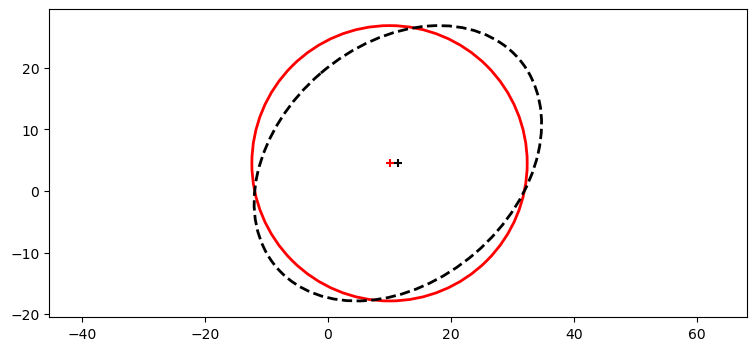

In [17]:
from filterpy.stats import plot_covariance_ellipse

dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

您可以看到椭圆的中心移动了少量（从 10 到 11.35），因为位置发生了变化。椭圆也拉长，显示了位置和速度之间的相关性。滤波器如何计算新值 $\mathbf{\bar P}$，它基于什么？请注意，我每次都将过程噪声`Q`设置为零，因此这不是由于我添加了噪声。现在讨论这个问题还为时过早，但回想一下，到目前为止，在每个过滤器中，预测步骤都会导致信息丢失。这里也是如此。一旦我们涵盖了更多的内容，我会给你细节。

#### **设计过程噪声**

快速回顾过程噪声。一辆汽车在打开巡航控制的情况下沿着道路行驶;它应该以恒定的速度行驶。我们对此进行建模 $\bar x_k=\dot x_k\Delta t + x_{k-1}$。但是，它受到许多未知因素的影响。巡航控制无法完美地保持恒定速度。风会影响汽车，山丘和坑洼也是如此。乘客摇下车窗，改变汽车的拖曳曲线。

$$\dot{\mathbf x} = f(\mathbf x) + w$$

其中 $f(\mathbf x)$ 对状态转换进行建模，并且 $w$ 是 *过程模型的白噪声*.

我们将在卡尔曼滤波数学一章中学习如何从一组微分方程到卡尔曼滤波矩阵。在本章中，我们利用了牛顿已经为我们推导出运动方程的事实。现在，您只需要知道我们通过添加过程噪声协方差矩阵来考虑系统中的噪声 𝐐到协方差 𝐏.我们不添加任何东西到𝐱，因为噪声是白色的 - 这意味着噪声的平均值将为 0。如果平均值为 0， 𝐱不会改变。

单变量的卡尔曼滤波器使用`variance = variance + process_noise`去计算预测步的方差。多元卡尔曼滤波器也做类似的事情，本质上就是`P = P + Q`。我之所以说“本质上”，是因为协方差方程中还有其他与噪声无关的项，我们将在后面看到。

推导过程噪声矩阵可能要求很高，我们将把它推迟到卡尔曼数学章节。现在知道 $\mathbf Q$ 等于白噪声的预期值$w$，计算方式为 $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$。在本章中，我们将重点介绍修改此矩阵如何改变滤波器的行为。

对于本章的运动学问题，FilterPy 模块提供算函数去计算 $\mathbf Q$。`Q_discrete_white_noise`需要3个参数。`dim`, 指定了矩阵的维度, `dt`,是以秒为单位的时间步长,  `var`, 噪声的方差。简而言之，它在给定时间段内的噪声离散化，假设我们将在后面讨论。此代码计算以方差为 2.35、时间步长为 1 秒的白噪声$\mathbf Q$。

In [18]:
from filterpy.common import Q_discrete_white_noise

# 初始化过程噪声(白噪声)
Q = Q_discrete_white_noise(dim=2, dt=1, var=2.35)
print(Q)

[[0.588 1.175]
 [1.175 2.35 ]]


#### **设计控制函数**

卡尔曼滤波器不仅过滤数据，还允许我们去合并机器人和飞机等系统的控制输入。假设我们正在控制一个机器人。在每个时间步长，我们都会根据机器人的当前位置与期望位置向机器人发送转向和速度信号。卡尔曼滤波方程将这些知识整合到滤波方程中，根据当前速度和驱动电机的控制输入创建预测位置。请记住，我们从不丢弃信息。

对于线性系统，控制输入的影响可以描述为一组线性方程组，我们可以用线性代数将其表示为：

$$\Delta\mathbf x = \mathbf{Bu}$$

这里 $\mathbf u$ 是 *控制输入*, 并且 $\mathbf B$ 是 *控制输入模型* or *控制函数*. For example, $\mathbf u$ 可能是控制车轮电机转动速度的电压, 并且乘以 $\mathbf B$ 得到收益率 $\Delta[\begin{smallmatrix}x\\\dot x\end{smallmatrix}]$. 换句话说, 它必须计算由于控制输入而变化，$\mathbf x$ 改变了多少。

因此，针对先验均值，完整卡尔曼滤波方程为：

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

这是调用 KalmanFilter.predict() 时计算的方程。

您的狗可能经过训练以响应语音命令。所有可用的证据表明我的狗没有任何控制输入，所以我设置 $𝐁$ 归零。在Python中，我们写：


In [19]:
# 我的狗不听我的命令
B = 0
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x = ', x)
print('P = ', P)

x =  [12.7  4.5]
P =  [[680.587 301.175]
 [301.175 502.35 ]]


设置 $\mathbf B$ and $\mathbf u$ 为零是不必要的，因为  `predict` 使用0作为默认值:


In [20]:
predict(x, P, F, Q)[0] == predict(x, P, F, Q, B, u)[0]
predict(x, P, F, Q)[1] == predict(x, P, F, Q, B, u)[1]

array([[ True,  True],
       [ True,  True]])

#### **预测：总结**

作为设计者，你的工作是设定下面这些矩阵：

* $\mathbf x$, $\mathbf P$: 状态和协方差
* $\mathbf F$,  $\mathbf Q$: 过程模型和噪声协方差
* $\mathbf{B,u}$: 可选, 控制矩阵 and 控制输入

### **更新步骤**

现在我们可以实现过滤器的更新步骤。您只需要再提供两个矩阵，它们很容易理解。

#### **设计测量函数**

卡尔曼滤波器在我们所谓的**测量空间**中计算更新步骤。我们在单变量章节中大多忽略了这个问题，因为它增加了复杂性。我们使用报告其位置的传感器跟踪狗的位置。计算残差很容易 - 从测量中减去滤波器的预测位置：

$$ \mathtt{residual} = \mathtt{measured\, \, position} - \mathtt{predicted\, \, position}$$

我们需要计算残差，因为我们按卡尔曼增益对其进行缩放以获得新的估计值。

如果我们尝试使用温度计跟踪温度，该温度计输出与温度读数相对应的电压，会发生什么？残差计算的方程将毫无意义;您不能从电压中减去温度。

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$

我们需要将温度转换为电压，以便执行减法。对于温度计，我们可以这样写：

```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```

卡尔曼滤波器通过让您提供一个将状态转换为测量的测量函数来概括这个问题。

**我们为什么要在测量领域工作？为什么不在状态空间中通过将电压转换为温度来工作，从而使残差成为温度差异?**

我们不能这样做，因为大多数测量值都是不可逆的。跟踪问题的状态包含隐藏变量 $\dot x$ ，无法将位置测量转换为包含速度的状态。另一方面，将包含位置和速度的状态转换为仅包含位置的等效“测量”是微不足道的。我们必须在测量空间中工作，以使残差的计算成为可能。

测量 $\mathbf z$ 和状态 $\mathbf x$ 是向量，因此我们需要使用矩阵来执行转换。执行此步骤的卡尔曼滤波方程为：

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

其中 $\mathbf y$ 是残差, $\mathbf{\bar x}$ 是先验, $\mathbf z$ 是测量值, and $\mathbf H$ 是测量函数(将状态映射到测量空间)。 所以我们去先验, 将其乘以 $\mathbf H$, 然后从测量值中减去。这给了我们在测量空间中测量值与预测的偏差。


<img src="lean/figs/residual_chart_with_h.png">

我们需要设计  $\mathbf H$ 以便于 $\mathbf{H\bar x}$ 产生测量值。对于这个问题，我们有一个测量位置的传感器，所以 $\mathbf z$ 将是拥有一个变量向量：

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

残差方程的形式为:

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ 必须是 1x2 维度的矩阵，因为 $\mathbf{Hx}$ 的维度是 1x1. 回想矩阵乘法， $m\times n$ 矩阵乘以 $n\times p$ 矩阵，产生$m\times p$ 维度的矩阵。

我们想要位置 $x$ 乘以 1 得到相应的位置的测量值。我们不需要使用速度来找到相应的测量值，因此我们将 $\dot x$ 乘以 0 。

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

因此，对于我们的卡尔曼滤波器，我们设置：

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

In [21]:
# 测量函数，将状态映射到测量空间
H = np.array([[1., 0.]])
H, H.shape

(array([[1., 0.]]), (1, 2))

我们已经设计了卡尔曼滤波器大部分内容。剩下的就是对传感器中的噪声进行建模。

#### **设计测量(Measurement)**

测量表示为$\mathbf z$，它是测量的平均值，$\mathbf R$是测量的协方差。

$\mathbf z$ 很容易。它包含所有的测量值为一个向量。我们仅仅有一个测量值，因此我们有：

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

如果我们有两个传感器或测量值，我们将有：

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$

测量噪声矩阵将传感器中的噪声建模为协方差矩阵。在实践中，这可能很困难。一个复杂的系统可能有许多传感器，它们之间的相关性可能不清楚，通常它们的噪声不是纯粹的高斯。例如，如果温度较高，则传感器可能会偏向于读取高读数，因此噪声在平均值的两侧分布不均匀。我们稍后将学习处理这些问题。

卡尔曼滤波方程使用协方差矩阵 $\mathbf R$ 表示测量噪声。矩阵的维度是 $m{\times}m$, 其中 $m$ 是传感器的数量。它是一个协方差矩阵，用于表示传感器之间的相关性。我们只有 1 个传感器，因此 $\mathbf R$ 是：

$$R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

如果 $\sigma^2_z$ 是 5 m$^2$，我们会有 $R = \begin{bmatrix}5\end{bmatrix}$. 

如果我们有两个位置传感器，第一个位置传感器的方差为 5 m$^2$ ，第二个方差为 5 m$^2$ ，我们会写

$$R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

我们将方差放在对角线上，因为这是一个协方差矩阵，其中方差位于对角线上，协方差（如果有的话）位于非对角线元素中。在这里，我们假设两个传感器之间的噪声没有相关性，因此协方差为 0。

对于我们的问题，我们只有一个传感器，因此我们可以将其实现为：

In [22]:
# 传感器的噪声，测量噪声
R = np.array([[5.]])
R, R.shape

(array([[5.]]), (1, 1))

我们通过调用 update 来执行更新

In [23]:
from filterpy.kalman import update

z = 1.0
x, P = update(x, P, z, R, H)
print('x = ', x)

x =  [ 1.085 -0.64 ]


跟踪所有这些变量是很麻烦的，所以 FilterPy 模块也用KalmanFilter类实现了卡尔曼过滤器。我将在本书的其余部分使用该类，但我想让你们看到这些函数的过程形式，因为我知道你们中的一些人不是面向对象编程的粉丝。

## **四、实现卡尔曼滤波器**

我已经为您提供了滤波器的所有代码，但现在让我们将其收集在一个地方。首先，我们构造一个`KalmanFilter`对象。我们必须用`dim_x`参数指定状态中的变量数,用`dim_z`指定测量值的数量。我们有两个状态变量和一个测量值。所以我们这样写：

```python
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
```
这将创建一个对象，其中包含所有卡尔曼滤波矩阵的默认值：

In [24]:
from filterpy.kalman import KalmanFilter

dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)                       # 状态变量初始值
print('R = ', dog_filter.R)                         # 传感器的方差
print('Q = \n', dog_filter.Q)                       # 过程模型的噪声协方差

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


现在，我们为我们的问题初始化了有效的矩阵和向量的值。我把它放在一个辅助函数中，以允许您为 `R`, `P`和 `Q`指定不同的初始值。我们将创建和运行其中的许多过滤器，这为我们节省了很多麻烦。

In [25]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    '''
        返回一个恒定速度模型的卡尔曼滤波器, 状态是[x dx].T
    '''
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]])                   # 位置和速度, 维度是[2, 1]
    kf.F = np.array([[1., dt],
                     [0, 1]])                       # 状态转移矩阵, 维度是[2, 2]
    
    kf.H = np.array([[1., 0]])                      # 测量函数, 维度是[1, 2]
    kf.R *= R                                       # 测量的不确定性, 维度是[1, 1]
    
    if np.isscalar(P):
        kf.P *= P                                   # 状态的协方差矩阵
    else:
        kf.P[:] = P                                 # [:] 表示深拷贝
        
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)          # 过程模型噪声
    else:
        kf.Q[:] = Q
        
    return kf

`KalmanFilter` 初始化 `R`, `P`, 和 `Q` 为单位矩阵, 因此`kf.P *= P`是一种快速指派所有对角线元素为相同的标量的方法。现在，我们创建滤波器：

In [26]:
dt = 0.1
x = np.array([0., 0.])
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

您可以通过在命令行上输入变量来检查筛选器所有属性的当前值。

In [27]:
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[0.    0.   ]
     [0.    0.001]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7fce0d555d30>

剩下的就是编写代码来运行卡尔曼滤波器。

In [28]:
from lean.kf_book.mkf_internal import plot_track

def run(x0=(0., 0.), P=500, R=0, Q=0, dt=1.0, track=None, zs=None, count=0, do_plot=True, **kwargs):
    '''
        track是狗的实际位置, zs是相应的测量值。
    '''
    # 如果没有数据提供,模拟狗的运动
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)               # 狗的实际位置和测量位置
    
    # 创建一个卡尔曼滤波器
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
    
    # 运行卡尔曼滤波器, 并且存储结果
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)                     # 后先验估计值
        cov.append(kf.P)                    # 后验估计的协方差
        
    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov
    

这是滤波器的完整代码，其中大部分是样板代码。我已经使它足够灵活，以支持本章中的多种用途，所以它有点冗长。让我们逐行完成它。

第一行检查您是否在数据中提供了测量数据。如果没有，它使用我们之前编写的compute_dog_data函数创建数据。

接下来的几行使用我们的辅助函数来创建卡尔曼滤波器。

```python
# create the Kalman filter
 kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
```

我们需要做的就是对每次测量执行卡尔曼滤波器的更新和预测步骤。`KalmanFilter`类提供了两种方法`predict()`和`update()`，并用于此目的。 `update()`h函数执行卡尔曼滤波器的测量更新步骤，并且它需要一个包含传感器测量值的变量。

如果没有存储结果的工作，循环读取：

```python
    for z in zs:
        kf.predict()
        kf.update(z)
```

每次调用 `predict` and `update` 去修改状态变量 `x` and `P`. 因此, 调用 `predict`之后, `kf.x` 是先验估计. 调用`update`之后, `kf.x` 就是后验估计. `data` 包含了狗的实际位置和测量位置, 因此我们使用 `[:, 1]` 获取测量值数组。

它真的没有比这更简单的了。当我们解决更复杂的问题时，此代码将基本保持不变;所有的工作都用于设置`KalmanFilter`矩阵; 执行滤波器是微不足道的。

代码的其余部分可以选择绘制结果，然后返回保存的状态和协方差。

让我们运行它。我们有 50 个测量值，噪声方差为 10，过程方差为 0.01。

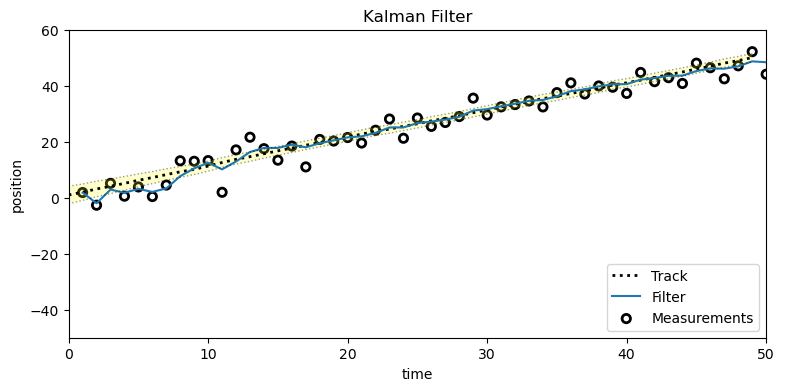

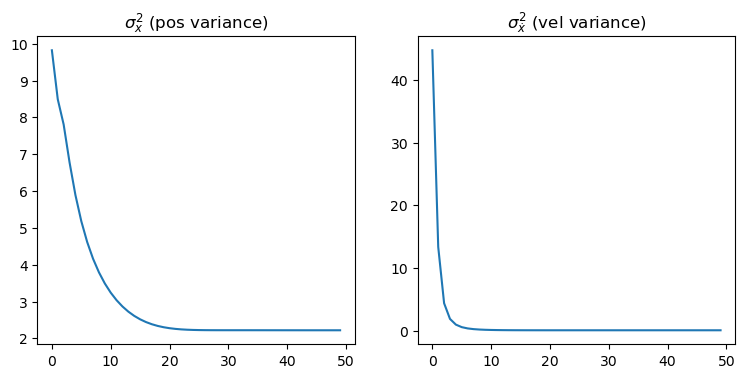

In [29]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

还有很多东西需要学习，但我们已经使用与鲁道夫·卡尔曼相同的理论和方程实现了卡尔曼滤波器！在你的GPS、客机、机器人等内部运行的代码与此很像。

第一个图将卡尔曼滤波器的输出与测量值和我们的狗的实际位置（标记为 Track）绘制。在初始值设置一段时间之后，滤波器的输出应该与狗的实际位置非常接近。黑色虚线之间的黄色阴影部分显示了滤波器方差的 1 个标准差，我将在下一段中对此进行解释。

接下来的两个图显示了 $x$ 和 $\dot x$的方差。 我已经绘制了 $\mathbf P$ 对角线元素随时间的变化。 回想一下，协方差矩阵的对角线包含了每一个状态变量的方差。 因此 $\mathbf P[0,0]$ 是 $x$ 的方差,  $\mathbf P[1,1]$ 是 $\dot x$ 的方差。 你可以看到它们的方差快速收敛到很小。

协方差矩阵 $\mathbf P$ 告诉我们滤波器的理论性能，假设我们告诉它的一切都是真的。回想一下，标准差是方差的平方根，大约 68% 的高斯分布发生在一个标准差内。如果至少68%的滤波器输出在一个标准偏差范围内，则滤波器可能表现良好。在上面的图表中，我将一个标准差显示为两条虚线之间的黄色阴影区域。在我看来，过滤器似乎略微超出了该范围，因此过滤器可能需要一些调整。

在单变量章节中，我们用比上面的代码简单得多的代码过滤了非常嘈杂的信号。但是，请注意，现在我们正在处理一个非常简单的示例 - 一个在一维空间和一个传感器中移动的物体。这大约是我们可以使用上一章中的代码计算的极限。相反，我们可以使用此代码实现非常复杂的多维过滤器，只需更改对过滤器变量的赋值即可。也许我们想在经济模型中跟踪 100 个维度。或者我们有一架带有GPS，INS，TACAN，雷达高度计，气压高度计和空速指示器的飞机，我们希望将所有这些传感器集成到一个模型中，以预测3D空间中的位置，速度和加速度。我们可以使用本章中的代码来做到这一点。

我想让你更好地了解高斯如何随时间变化，所以这里有一个3D图，显示了高斯每隔7个epoch（时间步长）。每 7 个epoch将它们分开足够多，因此可以独立看到每个。第一个高斯在 t=0时刻，它在左边。

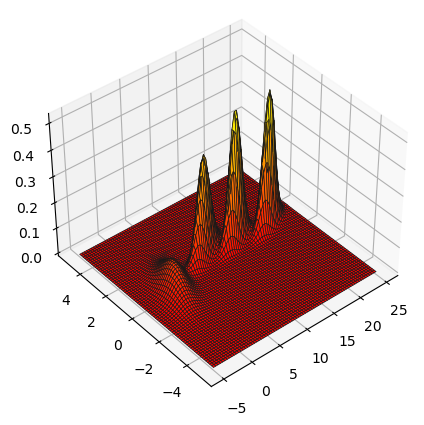

In [30]:
from lean.kf_book.book_plots import set_figsize, figsize
from lean.kf_book.nonlinear_plots import plot_gaussians

P = np.diag([3., 1.])
np.random.seed(3)

Ms, Ps = run(count=25, R=10, Q=0.01, P=P, do_plot=False)
with figsize(x=9, y=5):
    plot_gaussians(Ms[::7], Ps[::7], (-5,25), (-5, 5), 75)

### **Saver类**


在run()方法中，我编写了样板代码来保存过滤器的结果。

```python
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
```

有一种简单的方法可以避免这种情况。filtery.common 模块提供了 Saver 类，每次调用Saver.save()时，将保存卡尔曼滤波器类中的所有属性。让我们看看它的实际效果，然后我们将更多地讨论它。


In [31]:
from filterpy.common import Saver

kf = pos_vel_filter([0., 0.1], R=R, P=P, Q=Q, dt=1.)

s = Saver(kf)
for i in range(1, 6):
    kf.predict()
    kf.update([i])
    s.save()                                        # 保存当前状态

Saver对象现在包含卡尔曼过滤器对象的所有属性的列表。kf.x是筛选器的当前状态估计值。因此，s.x包含了循环内计算的已保存状态估计值：

In [32]:
s.x

[array([0.531, 0.304]),
 array([1.555, 0.763]),
 array([2.784, 1.036]),
 array([3.944, 1.105]),
 array([5.015, 1.086])]

您可以使用keys属性查看所有可用属性：

In [33]:
s.keys

['alpha',
 'likelihood',
 'log_likelihood',
 'mahalanobis',
 'dim_x',
 'dim_z',
 'dim_u',
 'x',
 'P',
 'Q',
 'B',
 'F',
 'H',
 'R',
 '_alpha_sq',
 'M',
 'z',
 'K',
 'y',
 'S',
 'SI',
 '_I',
 'x_prior',
 'P_prior',
 'x_post',
 'P_post',
 '_log_likelihood',
 '_likelihood',
 '_mahalanobis',
 'inv']

这里有许多属性我们还没有讨论过，但很多应该很熟悉。

此时，您可以编写代码来绘制这些变量中的任何一个。但是，`np.array`通常更有用，而不是`list`。调用`Saver.to_array()`会将列表转换为`np.array` 。有一个警告：如果任何属性的形状在运行过程中发生变化，将引发异常，因为要求所有元素的类型和大小相同。

如果您再次查看keys属性，您会发现`z`是选择之一。这是有希望的;显然，测量值`z`是为我们保存的。让我们绘制它(测量值)和估计值(后验估计,滤波之后的值)。

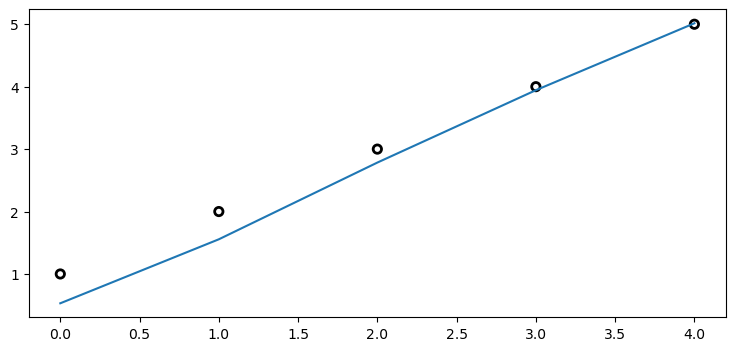

In [34]:
import matplotlib.pyplot as plt

s.to_array()
book_plots.plot_measurements(s.z)
plt.plot(s.x[:, 0])

虽然我已经在KalmanFilter类中演示了这一点，但它将适用于FilterPy实现的所有过滤器类。它也可能与您编写的任何类一起使用，因为它会检查对象以检索属性名称。我们将在整本书中使用这个类，以保持代码的可读性和简短性。使用 Saver 会减慢您的代码速度，因为幕后发生了很多事情，但对于学习和探索来说，便利性是无与伦比的。

## **五、卡尔曼滤波方程**


我们现在已准备好学习如何执行predict()和update()它们的计算。

对于符号来说，我是一名程序员，我习惯于阅读代码。

```python
x = x + 1
``` 

这不是一个等式，因为双方并不相等，而是一个指派。如果我们想用数学符号写这个，我们会写：

$$x_k = x_{k-1} + 1$$

卡尔曼滤波方程充斥着下标和上标，以保持方程在数学上的一致性。我发现这使得它们非常难以阅读。在本书的大部分内容中，我选择了无下标的作业。作为一名程序员，你应该明白，我向你展示的是实现要逐步执行的算法的赋值。一旦我们有一个具体的例子，我会详细说明这一点。

### **预测方程**

卡尔曼滤波器使用这些方程来计算先验 - 预测系统的下一个状态。它们计算先验平均值 ($\bar{\mathbf x}$) 和协方差 ($\bar{\mathbf P}$)。

$\underline{\textbf{均值-Mean}}$：

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

提醒一下，线性方程 $\mathbf{Ax} = \mathbf b$ 表示一个系统的方程组，其中，$\mathbf A$ 表示这些方程组的系数集。$\mathbf x$是变量的向量。执行乘法 $\mathbf{Ax}$ 计算得到右手边的值，表示为$\mathbf b$。

如果 $\mathbf F$ 包含给定时间步长的状态转换, 然后乘积 $\mathbf{Fx}$ 计算该转换之后的状态。 简单! 同样的, $\mathbf B$ 是控制函数, $\mathbf u$ 是控制输入, 因此 $\mathbf{Bu}$ 计算了控制对转换后状态的贡献。 因此, 先验 $\mathbf{\bar x}$ 是 $\mathbf{Fx}$ 和 $\mathbf{Bu}$的和。

等效的一元方程为

$$\bar\mu = \mu + \mu_{move}$$

如果执行矩阵乘法 $\mathbf{Fx}$， 它将为$x$产生此等式。

让我们明确说明。回想在上一个章节中，$\mathbf F$ 的值：

$$\mathbf F = \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}$$

因此 $\mathbf{\bar x} = \mathbf{Fx}$ 对应于一组线性方程:

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

$\underline{\textbf{协方差-Covariance}}$

$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$

这个等式不那么容易理解，所以我们会花更多的时间在上面。

此等式的单变量版本为：

$$\bar\sigma^2 = \sigma^2 + \sigma^2_{move}$$

我们将运动的方差添加到估计的方差中，以反映知识的丢失。我们需要在这里做同样的事情，只是对于多元高斯来说，这并不容易。

我们不能简单的写为 $\mathbf{\bar P} = \mathbf P + \mathbf Q$。在多元高斯中，状态变量是 *相关的*。 这意味着什么? 我们对速度的了解并不完善, 但是，们把它加入到位置的计算中：

$$\bar x = \dot x\Delta t + x$$

由于我们不能完美了解 $\dot x$ 的值，因此 $\bar x = \dot x\Delta t + x$ 的和增加了不确定性。 B由于位置和速度是相关的，因此我们不能简单地添加协方差矩阵。 例如, 如果 $\mathbf P$ 和 $\mathbf Q$ 是对角矩阵，它们的和也是对焦矩阵。但我们知道位置和速度是相关的，因此非对角元素不应该为零。

正确的等式是：

$$\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q$$


表达式  $\mathbf{ABA}^\mathsf T$ 在线性代数中很常见。你可以把它想象成通过外项来投射中期。我们将在本书的其余部分多次使用它。我承认这对你来说可能是一个“神奇”的方程式。让我们来探索一下。

当我们初始化 $\mathbf P$ 时

$$\mathbf P = \begin{bmatrix}\sigma^2_x & 0 \\ 0 & \sigma^2_v\end{bmatrix}$$


$\mathbf{FPF}^\mathsf T$ 的值是：

$$\begin{aligned}
\mathbf{FPF}^\mathsf T &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\begin{bmatrix}\sigma^2_x & 0 \\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x&\sigma_v^2\Delta t\\  0 & \sigma^2_{v}\end{bmatrix}
\begin{bmatrix}1&0\\\Delta t&1\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x +  \sigma_v^2\Delta t^2  &  \sigma_v^2\Delta t \\
\sigma_v^2\Delta t & \sigma^2_{v}\end{bmatrix}
\end{aligned}$$

初始值 $\mathbf P$ 在位置和速度之间没有协方差。  位置通过 $\dot x\Delta t + x$ 方程计算, 因此位置和速度之间存在相关性。 乘法 $\mathbf{FPF}^\mathsf T$ 计算协方差为 $\sigma_v^2 \Delta t$。 确切的值并不重要; 你只需要认识到 $\mathbf{FPF}^\mathsf T$ 过程模型自动地计算位置和速度之间的协方差!

另一种思考方式是来自于 $\mathbf{Fx}$ 乘法。 及时向前投射 $\mathbf x$ 。 $\mathbf {FP}$ 似乎是等效的操作, 但是 $\mathbf P$ 是一个矩阵，而 $\mathbf x$ 是一个向量. 尾部的 $\mathbf F^\mathsf T$ 确保我们乘了 $\mathbf F$ 的行和列. 在计算 $\mathbf{FPF}^\mathsf T$ 的第二行，我们有 $\mathbf{FP}$ 的值。 你可以看到它是一个上三角矩阵，因为我们还没有完全把 $\mathbf F$ 合并到乘法。

如果你对线性代数和统计学有一些经验，这可能会有所帮助。预测引起的协方差可以建模为预测步骤中误差的期望值，由该方程给出。

$$\begin{aligned}
\bar{\mathbf P} &= \mathbb E[(\mathbf{Fx - \bar \mu})(\mathbf{Fx - \bar\mu})^\mathsf T]\\
 &= \mathbf F\, \mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]\, \mathbf F^\mathsf T
\end{aligned}$$

当然, $\mathbb E[\mathbf{(x- \bar\mu)(x- \bar\mu)}^\mathsf T]$ 肯定是 $\mathbf P$, 我们给出

$$\bar{\mathbf P} = \mathbf{FPF}^\mathsf T$$

让我们看看它的效果。 在这里我使用 $\mathbf F$ 从我们的过滤器和投影状态向前 0.6 秒。我这样做了五次，所以你可以看到如何 $\mathbf{\bar P}$ 继续变化。


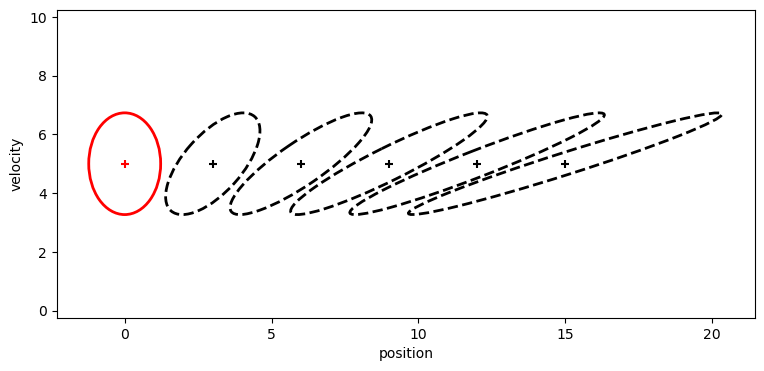

In [35]:
dt = 0.6

x = np.array([0., 5.])
F = np.array([[1, dt], [0, 1.]])
P = np.diag([1.5, 3.0])
plot_covariance_ellipse(x, P, edgecolor='r')

for _ in range(5):
    x = F @ x
    P = F @ P @ F.T
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
    
book_plots.set_labels(x='position', y='velocity')

您可以看到，当速度为 5 时，在0.6秒，位置方向移动了 3 个单位。在每一步中，椭圆的宽度都较大，表明由于我们添加了$\dot x\Delta t$ 到 x,所以丢失了有关的位置信息。高度没有改变 - 我们的系统模型说速度不会改变，所以我们对速度的信念不会改变。随着时间的流逝，您可以看到椭圆变得越来越倾斜。回想一下，倾斜表示相关性。$\mathbf F$ 表示了 $x$ 和 $\dot x$ 线性相关，其表达式为 $\bar x = \dot x \Delta t + x$。 The $\mathbf{FPF}^\mathsf T$ 计算正确地合并此相关性到协方差矩阵。

这是上述等式的动画，并且允许你去设计改变 $\mathbf F$ 去看它是如何影响 $\mathbf P$ 的形状的。 这个 `F00` 滑块会影响F[0, 0]的值. `covar` 设置位置和速度的初始协方差($\sigma_x\sigma_{\dot x}$). 我建议至少回答这些问题。

* 如果 $x$ 与 $\dot x$ 是不相关的? (set F01 to 0, the rest at defaults)
* 如果 $x = 2\dot x\Delta t + x_0$? (set F01 to 2, the rest at defaults)
* 如果 $x = \dot x\Delta t + 2x_0$? (set F00 to 2, the rest at defaults)
* 如果 $x = \dot x\Delta t$?  (set F00 to 0, the rest at defaults)


In [36]:
from ipywidgets import interact
from lean.kf_book.book_plots import IntSlider, FloatSlider

def plot_FPFT(F00, F01, F10, F11, covar):   
    plt.figure()
    dt = 1.
    x = np.array((0, 0.))
    P = np.array(((1, covar), (covar, 2)))
    F = np.array(((F00, F01), (F10, F11)))
    plot_covariance_ellipse(x, P)
    plot_covariance_ellipse(x, F @ P @ F.T, ec='r')
    plt.gca().set_aspect('equal')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    #plt.title(str(F))
    plt.xlabel('position')
    plt.ylabel('velocity')
                 
interact(plot_FPFT, 
         F00=IntSlider(value=1, min=0, max=2), 
         F01=FloatSlider(value=1, min=0, max=2, description='F01(dt)'),
         F10=FloatSlider(value=0, min=0, max=2),
         F11=FloatSlider(value=1, min=0, max=2),
         covar=FloatSlider(value=0, min=0, max=1));

interactive(children=(IntSlider(value=1, continuous_update=False, description='F00', max=2), FloatSlider(value…

（如果您以静态形式阅读本文：在线运行此内容的说明如下：https://git.io/vza7b）。或者，使用下面的链接转到活页夹，然后从那里打开此笔记本。

http://mybinder.org/repo/rlabbe/Kalman-and-Bayesian-Filters-in-Python

### **更新公式**

更新方程看起来比预测方程更为混乱，但这主要是由于卡尔曼滤波器计算了测量空间中的更新。这是因为测量值是不可逆的。例如，考虑一个传感器，它为目标提供范围。将范围转换为位置是不可能的 - 圆中无限多个位置将产生相同的范围。另一方面，我们总是可以计算给定位置（状态）的范围（测量）。

在我继续之前，请记住，我们正在尝试做一些非常简单的事情：选择在测量和预测之间选择的新估计值，如下图所示：

<img src="lean/figs/residual_chart.png">

方程会很复杂，因为状态有多个维度，但这种操作就是我们正在做的事情。不要让方程式分散你对这个想法的简单性的注意力。

$\underline{\textbf{系统不确定性}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R$

为了在测量空间中工作，卡尔曼滤波器必须将协方差矩阵投影到测量空间中。 数学公式为 $\mathbf{H\bar PH}^\mathsf T$, 其中 $\mathbf{\bar P}$ 是 *先验* 协方差 且 $\mathbf H$ 是测量函数。

你应该意识到 $\mathbf{ABA}^\mathsf T$ 形式 -预测步骤中使用状态转移函数 $\mathbf{FPF}^\mathsf T$ 去更新 $\mathbf P$。 这里, 我们使用同样的方式(测量函数)去执行更新步骤。 线性代数正在为我们改变坐标系。 

一旦协方差转换到测量空间，我们就需要考虑传感器噪声。这是非常简单的 - 我们只需要添加矩阵。 结果被称为 *系统不确定性* 或者 *预测协方差*。

如果你忽略等式中的 $\mathbf H$ 项，此方程等价于卡尔曼增益的单变量方程中的分母：

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

比较系统不确定性和预测协方差的方程：

$$\begin{aligned}
\mathbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$

在每个方程中 $\mathbf P$ 被放入不同的空间，分别是 $\mathbf H$ 函数或者 $\mathbf F$ 函数。 然后我们添加与该空间关联的噪声矩阵。

$\underline{\textbf{卡尔曼增益}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

回头看下残差图。一旦我们有了预测和测量，我们需要在两者之间的某个地方选择一个估计值。如果我们对测量有更多的确定性，估计值将更接近它。相反，如果我们对预测有更多的确定性，那么估计值将更接近它。

在单变量章节中，我们使用此等式缩放平均值

$$\mu =\frac{\bar\sigma^2 \mu_z + \sigma_\mathtt{z}^2 \bar\mu} {\bar\sigma^2 + \sigma_\mathtt{z}^2}$$

我们简化为

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

这给了我们

$$K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2}$$

$K$ 是 *卡尔曼增益*, 并且它是一个 0 和 1之间的实数。 确保您了解它是如何在预测和测量之间选择平均值的。卡尔曼增益是一个百分比或比率  - 如果 K 是 .9， 则需要 90% 的测量值 和 10% 预测值。

对于多元的卡尔曼滤波器 $\mathbf K$ 是一个向量, 不是一个标量。 这里是等式: $\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$. 这是一个 *比例* 吗? 我们可以将矩阵的逆函数视为线性代数求倒数的方式。除法不是为矩阵定义的，但以这种方式思考它是有用的。因此，我们可以读取以下等$\textbf{K}$ 作为意义。

$$\begin{aligned} \mathbf K &\approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} \\
\mathbf K &\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{prediction} + \mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
\end{aligned}$$

卡尔曼增益方程根据我们对预测与测量的信任程度来计算比率。我们在前面的每一章都做了同样的事情。这个方程很复杂，因为我们通过矩阵在多个维度上做到这一点，但这个概念很简单。这 $\mathbf H^\mathsf T$ 术语不太清楚，我很快就会解释。如果忽略该项，卡尔曼增益的方程与单变量情况相同：将先验的不确定性除以先验和测量的不确定性之和。

$\underline{\textbf{残差}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

这是一个简单的方法，因为我们在设计测量函数时已经涵盖了这个等式 $\mathbf H$。回想一下，测量函数将状态转换为测量。 因此 $\mathbf{Hx}$ 转换 $\mathbf x$ 为等效的测量值。 一旦完成, 我们将会从测量 $\mathbf z$ 中减去，得到残差 - 测量与预测之间的差异。

单变量方程为：

$$y = z - \bar x$$

并且清楚地计算了同样的事情，但仅在一个维度上。

$\underline{\textbf{状态更新}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

我们选择我们的新状态沿着残差方向，按卡尔曼增益缩放。 缩放执行 $\mathbf{Ky}$, 在 $\mathbf K$ 中包含 $\mathbf H^\mathsf T$ 术语，它不仅缩放残差，还将其转换到状态空间。将其结果加上先验(prior), 产生等式: $\mathbf x =\mathbf{\bar x} + \mathbf{Ky}$。 让我写出来 $\mathbf K$，以便于我们可以看到它完整的计算过程。

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T\mathbf y
\end{aligned}$$

也许比较好的方式是了解ratio，重写估计的过程如下：

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$

这和单变量形式之间的相似性应该是显而易见的：

$$\mu = (1-K)\bar\mu + K\mu_\mathtt{z}$$

$\underline{\textbf{协方差更新}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ 是一个单位矩阵, 并且是一个在多个维度表示 $1$ 的方式。 $\mathbf H$ 是我们的测量函数, 而且是一个常数。我们可以将等式视为 $\mathbf P = (1-c\mathbf K)\mathbf P$。其中，$\mathbf K$ 是我们使用的预测量与测量量的比率。如果 $\mathbf K$ 是很大，然后 $(1-\mathbf{cK})$ 就会很小, 那么 $\mathbf P$ 也将变小. 如果 $\mathbf K$ 是很小的, 然后 $(1-\mathbf{cK})$ 是很大的, 那么 $\mathbf P$ 将会相对变大。这意味着我们通过卡尔曼增益的某个因素来调整不确定性的大小。

这个等式在数值上可能不稳定，我不在 FilterPy 中使用它。随着时间的推移，减法会破坏对称性并导致浮点误差。稍后我将分享这个方程的更复杂但数值稳定的形式。

### **不使用FilterPy的示例**

FilterPy向我们隐藏了实现的细节。通常你会欣赏这一点，但让我们在没有 FilterPy 的情况下实现最后一个过滤器。为此，我们需要将矩阵定义为变量，然后显式实现卡尔曼滤波方程。

在这里，我们初始化我们的矩阵：

In [37]:
dt = 1.0    
R_var = 10                      # 测量方差
Q_var = 0.01                    # 过程噪声

x = np.array([[10.0, 4.5]]).T   # 滤波器初始状态，位置和速度
P = np.diag([500, 49])          # 状态变量的协方差矩阵
F = np.array([[1, dt], 
              [0, 1]])          # 状态转移矩阵
H = np.array([[1.0, 0.0]])      # 测量函数
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

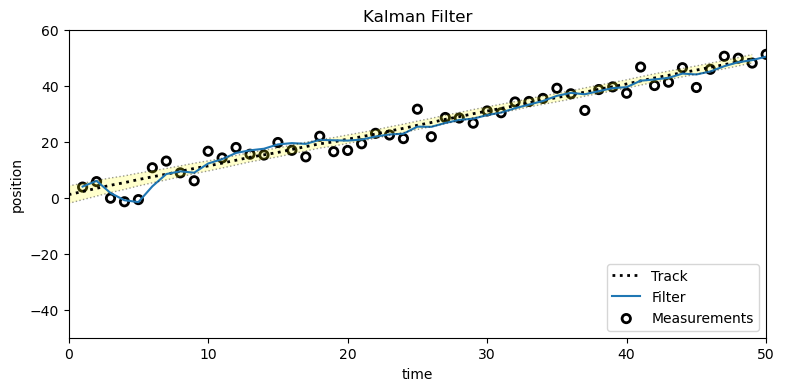

In [38]:
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs,cov = [], []
for z in zs:
    # 预测
    x = F @ x                           # 维度是2*2 x 2*1 = 2*1
    P = F @ P @ F.T + Q                 # 维度是2*2 x 2*2 x 2*2 + 2*2 = 2*2

    # 更新
    S = H @ P @ H.T + R                 # 维度是1*2 x 2*2 x 2*1 = 1*1
    K = P @ H.T @ inv(S)                # 维度是2*2 x 2*1 x 1*1 = 2*1
    y = z - H @ x                       # 维度是1*1- 1*2 x 2*1 = 1*1
    
    x = x + K * y                       # 维度是2*1 + 2*1 x 1*1 = 2*1
    P = P - K @ H @ P                   # 维度是2*2 - 2*1 x 1*2 x 2*2 = 2*2

    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False)

结果与 FilterPy 版本相同。你喜欢哪个取决于你。我不喜欢用变量污染我的命名空间，例如  `x`、`P`等; 对我来说，`dog_filter.x`更具可读性。

更重要的是，此示例要求您记住卡尔曼滤波器的方程并对其进行编程。迟早你会犯错误。FilterPy 的版本确保您的代码正确无误。另一方面，如果您在定义中犯了错误，例如 $\mathbf H$ 列向量而不是行向量，FilterPy 的错误消息将比此显式代码更难调试。

FilterPy 的 KalmanFilter 类提供了额外的功能，例如平滑、批处理、淡入淡出的内存过滤、最大似然函数的计算等。您无需显式编程即可获得所有这些功能。

### **总结**


我们已经学会了卡尔曼滤波方程。在这里，它们都在一起供您查看。有很多东西需要学习，但我希望当你经历每一次，你认识到它与单变量滤波器中的方程的亲属关系。在卡尔曼数学一章中，我将向您展示，如果我们设置 𝐱 这些方程恢复到单变量滤波器的方程。这并不“像”单变量过滤器 - 它是它的多维实现。

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$

我想分享一种方程的形式，你将在文献中看到。有许多不同的符号被系统的使用，但这可以让您了解会发生什么。

 $$
\begin{aligned}
\hat{\mathbf x}_{k\mid k-1} &= \mathbf F_k\hat{\mathbf x}_{k-1\mid k-1} + \mathbf B_k \mathbf u_k  \\
\mathbf P_{k\mid k-1} &=  \mathbf F_k \mathbf P_{k-1\mid k-1} \mathbf F_k^\mathsf T + \mathbf Q_k \\        	
\tilde{\mathbf y}_k &= \mathbf z_k - \mathbf H_k\hat{\mathbf x}_{k\mid k-1}\\
\mathbf{S}_k &= \mathbf H_k \mathbf P_{k\mid k-1} \mathbf H_k^\mathsf T + \mathbf R_k \\
\mathbf K_k &= \mathbf P_{k\mid k-1}\mathbf H_k^\mathsf T \mathbf{S}_k^{-1}\\
\hat{\mathbf x}_{k\mid k} &= \hat{\mathbf x}_{k\mid k-1} + \mathbf K_k\tilde{\mathbf y}_k\\
\mathbf P_{k|k} &= (I - \mathbf K_k \mathbf H_k) \mathbf P_{k|k-1}
\\\end{aligned}
$$

这种表示方法使用贝叶斯 $a\mid b$ 符号, 它意味着在给定证据 $b$ 条件下的 $a$。 这个帽子意思是估计。 因此 $\hat{\mathbf x}_{k\mid k}$ 表示状态 $\mathbf x$ 的估计，在步骤 $k$ (第一个 k)，在给定步骤 $k$ (第二个 k)的证据。 换句话说，它就是后验。 $\hat{\mathbf x}_{k\mid k-1}$ 表示状态变量 $\mathbf x$ 的估计，在步骤 $k$，在给定 $k - 1$ 步骤的估计值时。 换句话说，它就是先验。

这种符号复制自维基百科[1]，允许数学家准确地表达自己。在正式出版物中，展示结果，采用这种精确表示是必要的。作为一名程序员，我发现它相当不可读。我习惯于考虑变量在程序运行时更改状态，并且不会为每个新计算使用不同的变量名称。文献中没有商定的格式，因此每个作者都会做出不同的选择。我发现在书籍和论文之间快速切换具有挑战性，因此采用了我公认的不太精确的符号。数学家可能会给我写严厉的电子邮件，但我希望程序员和学生会为我的简化符号感到高兴。

符号系统附录列出了不同作者使用的符号。这带来了另一个困难。不同的作者使用不同的变量名称。 𝐱 相当普遍，但在那之后是任何人的猜测。例如，通常使用 一个 A 对于我所说的 𝐅 .您必须仔细阅读，并希望作者定义它们的变量（它们通常不会）。

如果你是一个试图理解论文方程的程序员，我建议从删除所有的上标、下标和变音符开始，用一个字母代替它们。如果你每天都使用这样的方程，这是多余的建议，但是当我阅读时，我通常会试图理解计算流程。对我来说，更容易记住和理解的是，在当前步骤中 $P$ 表示更新 $P$ 的值，通过上一步骤的值的计算,而不是试着去记住 $P_{k-1}(+)$ 的表示, 而且它与 $P_k(-)$ 是什么关系, 如果有的话，以及其中任何一个与我 5 分钟前阅读的论文中使用的完全不同的符号有何关系。


## **练习：显示隐藏变量的效果**

在我们的过滤器中，速度是一个隐藏变量。如果我们在状态下不使用速度，过滤器将如何执行？

编写使用状态 $\mathbf x=\begin{bmatrix}x\end{bmatrix}$ 的卡尔曼滤波器，并将其与使用状态变量 $\mathbf x=\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$ 的滤波器进行比较。

#### **求解**

我们已经为位置和速度实现了卡尔曼滤波器，因此我将提供代码而不带太多注释，然后绘制结果。

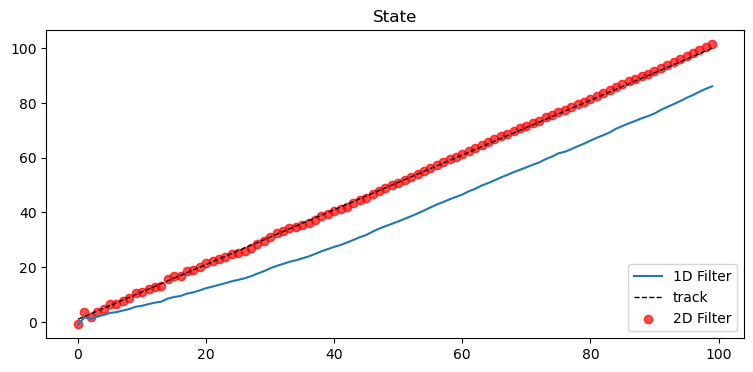

In [39]:
from math import sqrt
from numpy.random import randn

def univariate_filter(x0, P, R, Q):
    f = KalmanFilter(dim_x=1, dim_z=1, dim_u=1)
    f.x = np.array([[x0]])
    f.P *= P
    f.H = np.array([[1.]])
    f.F = np.array([[1.]])
    f.B = np.array([[1.]])
    f.Q *= Q
    f.R *= R
    return f

def plot_1d_2d(xs, xs1d, xs2d):
    plt.plot(xs1d, label='1D Filter')
    plt.scatter(range(len(xs2d)), xs2d, c='r', alpha=0.7, label='2D Filter')
    plt.plot(xs, ls='--', color='k', lw=1, label='track')
    plt.title('State')
    plt.legend(loc=4)
    plt.show()
    
def compare_1D_2D(x0, P, R, Q, vel, u=None):
    # storage for filter output
    xs, xs1, xs2 = [], [], []

    # 1d KalmanFilter
    f1D = univariate_filter(x0, P, R, Q)

    #2D Kalman filter
    f2D = pos_vel_filter(x=(x0, vel), P=P, R=R, Q=0)
    if np.isscalar(u):
        u = [u]
    pos = 0 # true position
    for i in range(100):
        pos += vel
        xs.append(pos)

        # control input u - discussed below
        f1D.predict(u=u)
        f2D.predict()
        
        z = pos + randn()*sqrt(R) # measurement
        f1D.update(z)
        f2D.update(z)
        
        xs1.append(f1D.x[0])
        xs2.append(f2D.x[0])
    plt.figure()
    plot_1d_2d(xs, xs1, xs2)

compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1.) 

#### **讨论**

将速度纳入状态的滤波器比仅跟踪位置的滤波器产生更好的估计值。单变量滤波器无法估计速度或位置变化，因此它滞后于跟踪的对象。

在单变量卡尔曼滤波器章节中，我们有一个预测方程的控制输入：u

```python
    def predict(self, u=0.0):
        self.x += u
        self.P += self.Q
```

让我们尝试指定控制输入：


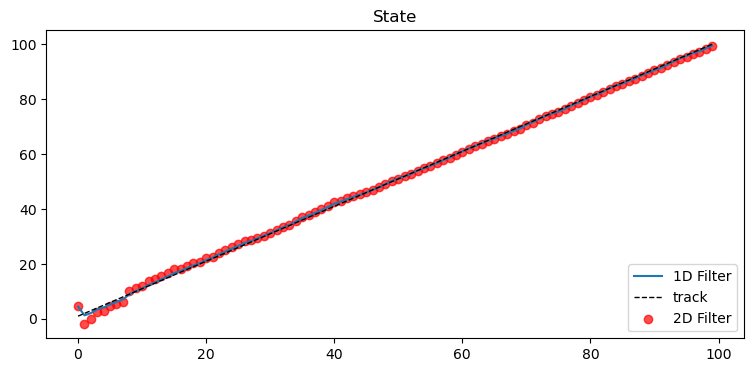

In [40]:
compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=1., u=1.) 

在这里，两个滤波器的性能相似，也许单变量滤波器的跟踪更加缓慢。但是让我们看看当实际速度`vel`与控制输入`u`不同时会发生什么：

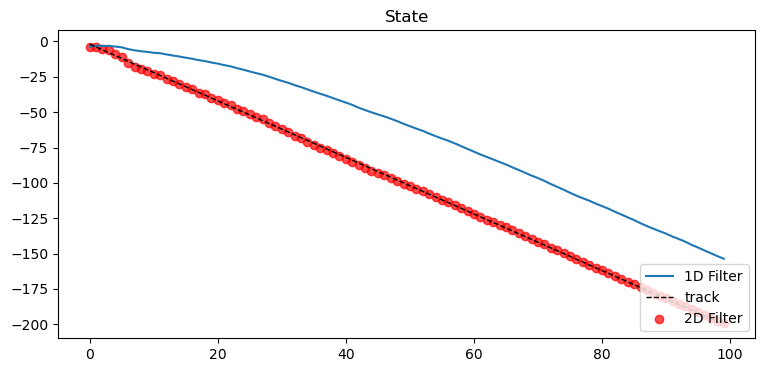

In [41]:
compare_1D_2D(x0=0, P=50., R=5., Q=.02, vel=-2., u=1.) 

如果我们在跟踪一个机器人，我们也在控制单变量滤波器可以做得很好，因为控制输入允许过滤器做出准确的预测。但是，如果我们被动跟踪，除非我们能够对速度做出准确的先验猜测，否则控制输入没有多大帮助。这几乎是不可能的。

### **如何计算速度**

我还没有解释过滤器如何计算速度或任何隐藏变量。如果我们插入为每个过滤器矩阵计算的值，我们可以看到会发生什么。

首先，我们需要计算系统的不确定性。

$$\begin{aligned}
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
&= \begin{bmatrix} 1 & 0\end{bmatrix}
\begin{bmatrix}\sigma^2_x & \sigma_{xv} \\ \sigma_{xv} & \sigma^2_v\end{bmatrix}
\begin{bmatrix} 1 \\ 0\end{bmatrix} + \begin{bmatrix}\sigma_z^2\end{bmatrix}\\
&= \begin{bmatrix}\sigma_x^2 & \sigma_{xv}\end{bmatrix}\begin{bmatrix} 1 \\ 0\end{bmatrix}+ \begin{bmatrix}\sigma_z^2\end{bmatrix} \\
&= \begin{bmatrix}\sigma_x^2 +\sigma_z^2\end{bmatrix}
\end{aligned}$$

现在我们有 𝐒 我们可以得到卡尔曼增益的值：

$$\begin{aligned}
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
&= \begin{bmatrix}\sigma^2_x & \sigma_{xv} \\ \sigma_{xv} & \sigma^2_v\end{bmatrix}
\begin{bmatrix} 1 \\ 0\end{bmatrix}
\begin{bmatrix}\frac{1}{\sigma_x^2 +\sigma_z^2}\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x  \\ \sigma_{xv}\end{bmatrix}
\begin{bmatrix}\frac{1}{\sigma_x^2 +\sigma_z^2}\end{bmatrix} \\
&= \begin{bmatrix}\sigma^2_x/(\sigma_x^2 +\sigma_z^2)  \\ \sigma_{xv}/(\sigma_x^2 +\sigma_z^2)\end{bmatrix}
\end{aligned}
$$

换句话说，卡尔曼增益为 $x$ 是

$$K_x = \frac{VAR(x)}{VAR(x)+VAR(z)}$$

从单变量案例中，您应该非常熟悉这一点。

卡尔曼增益为速度 $\dot x$ 是

$$K_{\dot x} = \frac{COV(x, \dot x)}{VAR(x)+VAR(z)}$$

这有什么影响？回想一下，我们将状态计算为

$$\begin{aligned}\mathbf x 
&=\mathbf{\bar x}+\mathbf K(z-\mathbf{Hx)} \\
&= \mathbf{\bar x}+\mathbf Ky\end{aligned}$$

这里残差 $y$ 是一个标量。因此它与 $\mathbf K$ 的每一个元素相乘。因此我们有：

$$\begin{bmatrix}x \\ \dot x\end{bmatrix}=\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} + \begin{bmatrix}K_x \\ K_{\dot x}\end{bmatrix}y$$

这给出了这个系统方程组：

$$\begin{aligned}x& = \bar x + yK_x\\
\dot x &= \bar{\dot x} + yK_{\dot x}\end{aligned}$$

预测 $\bar x$ 的计算为 $x + \bar x \Delta t$。 如果预测是完美的，那么残差将为 $y=0$ (忽略测量中的噪声)，并且速度的估计值将保持不变。 另一方面，如果速度估计非常糟糕，那么预测将非常糟糕，残差也将会非常大: $y >> 0$. 在这个例子中，我们使用 $yK_{\dot x}$ 更新速度估计值。 $K_{\dot x}$ 与 $COV(x,\dot x)$ 成正比。 因此，速度由位置误差(残差)乘以与位置和速度之间的协方差成正比的值来更新。相关性越高，校正越大。

为了形成完全闭环, $COV(x,\dot x)$ 是 $\mathbf P$ 的非对角线元素. 回想一下，这些值是由 $\mathbf{FPF}^\mathsf T$ 计算得到的。 因此，位置和速度的协方差是在预测步骤期间计算的。 速度的卡尔曼增益与该协方差成正比，我们根据上一个迭代(epoch)乘以与此协方差成比例的值的不准确程度来调整速度估计值。

综上所述，这些线性代数方程你可能不熟悉，但计算其实很简单。它本质上与我们在g-h过滤器中执行的计算相同。本章中的常量不同，因为我们考虑了过程模型和传感器中的噪声，但数学是相同的。

### **调整滤波器**

让我们开始改变我们的参数，看看各种变化的效果。这是使用卡尔曼滤波器做的非常正常的事情。对我们的传感器进行精确建模是困难的，而且通常是不可能的。不完美的模型意味着我们的滤波器输出不完美。工程师花费大量时间调整卡尔曼滤波器，以便它们在实际传感器上表现良好。我们现在将花时间了解这些变化的影响。当您了解每个变化的影响时，您将对如何设计卡尔曼滤波器产生直觉。设计卡尔曼滤波器既是一门艺术，也是一门科学。我们正在用数学对物理系统进行建模，模型并不完美。

我么来看看测量噪声 $\mathbf R$ 和 过程噪声 $\mathbf Q$ 的影响。 我们希望看到设置不同的 $\mathbf R$ 和 $\mathbf Q$ 的效果, 所以我给测量值的方差为 225 米平方。 这是非常大的，但它放大了各种设计选择对图形的影响，使其更容易识别正在发生的事情。 我们的第一个实验是保持 $\mathbf R$ 不变，改变 $\mathbf Q$。

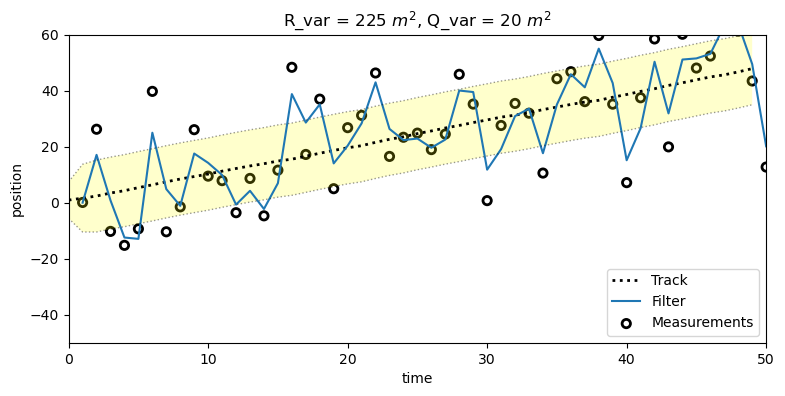

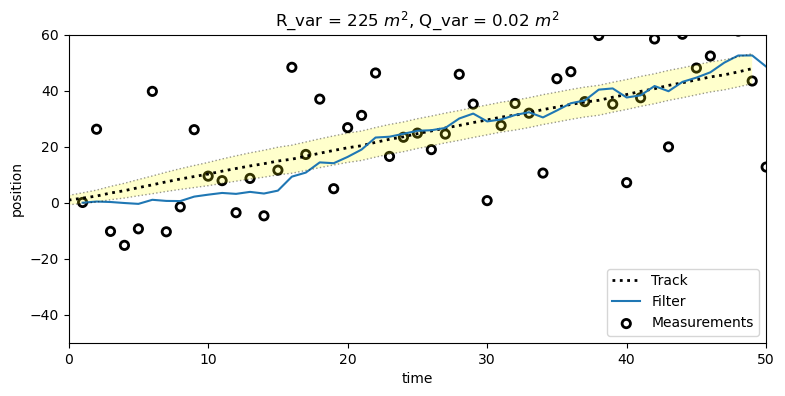

In [42]:
from numpy.random import seed
seed(2)

trk, zs = compute_dog_data(z_var=225, process_var=0.02, count=50)

run(track=trk, zs=zs, R=225, Q=200, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 20 $m^2$')
run(track=trk, zs=zs, R=225, Q=.02, P=P, plot_P=False, 
    title='R_var = 225 $m^2$, Q_var = 0.02 $m^2$');


第一个图中，滤波器应该紧跟带有噪声的测量值。在第二个图中，滤波器应该与测量值有很大差异，并且比第一个图中更接近直线。为什么 𝐐 会产生这样的影响呢？

让我们提醒自己，过程不确定性一词的含义。考虑一下球的跟踪问题，我们可以通过数学准确地模拟它在真空中的行为，但是对于风，不同的空气密度，温度以及表面不完美的旋转球，我们的模型将与现实背道而驰。

在第一种情况下，我们设置 `Q_var=20 m^2`, 这是相当大的。 在物理术语中，这是告诉过滤器 "我不相信我的运动预测步骤"，因为我们说速度的方差是 20。 严格来说, 我们告诉滤波器有很多外部噪声，我们没有采用 $\small{\mathbf F}$ 建模 ,但这样做的结果是不信任运动预测步骤。 过滤器将计算速度 ($\dot x$), 但大多数情况下忽略它，因为我们告诉过滤器计算非常可疑。因此，滤波器除了测量值之外没有什么可信任的，因此它密切跟踪测量值。

在第二种情况下，我们设置 `Q_var=0.02 m^2`, 这是非常小的。在物理术语中，我们告诉过滤器 "相信预测，它真的很好!"。更严格地说，这实际上意味着过程噪声量非常小 (方差 0.02 $m^2$), 因此过程模型非常准确。 因此，滤波器在测量值上下跳跃时最终会忽略一些测量值，因为测量值的变化与我们可靠的速度预测不匹配。

现在让我们设置 `Q_var` 为 $0.2\, m^2$, 并且将 `R_var` 提升到 $10,000\, m^2$。这告诉滤波器测量噪声非常大。

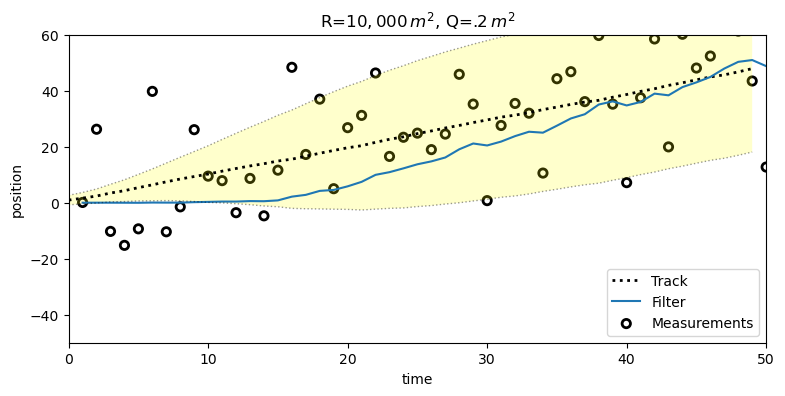

In [43]:
run(track=trk, zs=zs, R=10000, Q=.2, P=P, plot_P=False, 
    title='R=$10,000\, m^2$, Q=$.2\, m^2$');

这种影响可能是微妙的。我们创建了一个次优滤波器，因为实际测量噪声方差为 225 $m^2$, 而不是 10,000 $m^2$。 过将滤波器的测量噪声方差设置得如此之高，我们迫使滤波器有利于预测而不是测量。这可能会导致明显非常光滑和好看的结果。在上面的图表中，滤波器轨迹对您来说可能看起来非常好，因为它非常接近理想的路径。 但是, 开始时的“伟大”行为应该让您暂停 - 过滤器尚未收敛 ($\mathbf P$ 仍然很大)，所以它应该不可能很接近实际位置。我们可以看到 $\mathbf P$ 没有收敛，因为因为整个图表都用黄色背景着色，它表示 $\mathbf P$ 的大小。 让我们看看猜测一个坏的初始位置和速度的结果，假设初始位置是 50 m、初始速度是 1 m/s.

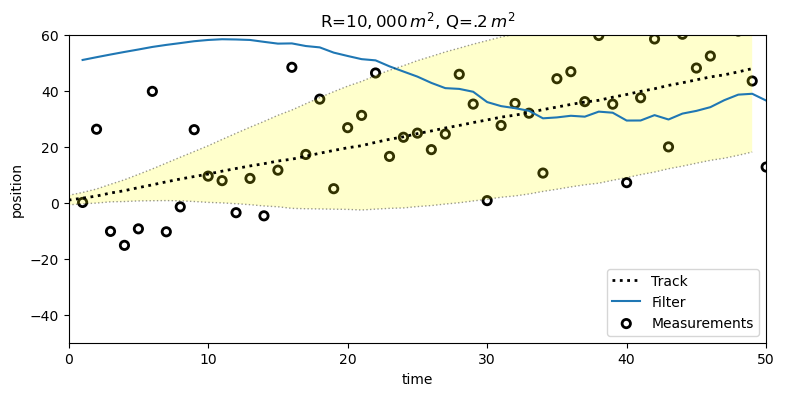

In [44]:
run(track=trk, zs=zs, R=10000, Q=.2, P=P, plot_P=False,
    x0=np.array([50., 1.]), 
    title='R=$10,000\, m^2$, Q=$.2\, m^2$');

在这里我们可以看到滤波器无法获取轨迹。发生这种情况是因为即使滤波器获得了相当好的测量值，它也会假设测量值很差，并最终在每一步从错误位置向前预测。如果您认为对于较小的测量噪声，错误的初始位置可能会给出类似的结果，让我们将其设置回正确的值 225 $m^2$。

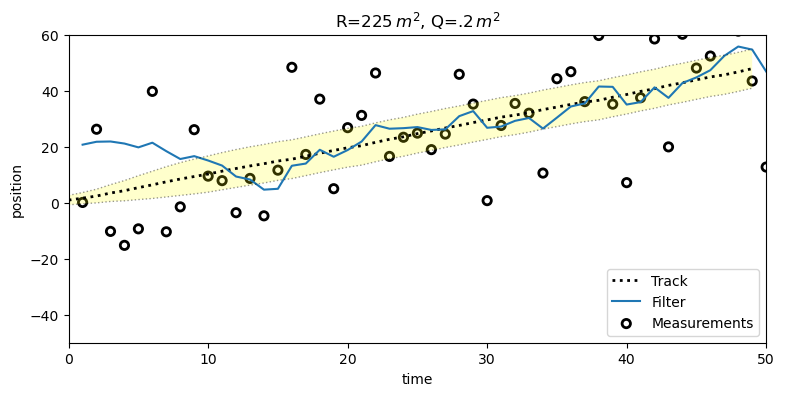

In [45]:
run(track=trk, zs=zs, R=225, Q=.2, P=P, plot_P=False, 
    x0=np.array([20., 1.]),
    title='R=$225\, m^2$, Q=$.2\, m^2$');

在这里，我们看到过滤器最初努力进行几次迭代以获取轨迹，但随后它准确地跟踪了我们的狗。事实上，这几乎是最佳的 - 我们没有设计 $\mathbf Q$ 最佳, 但是 $\mathbf R$ 是最佳的。 经验法则 $\mathbf Q$ 被设置为 $\frac{1}{2}\Delta a$ 到 $\Delta a$ 之间, 其中 $\Delta a$ 是加速度在采样周期之间变化的最大量。 这仅适用于我们在本章中所做的假设 - 加速度在每个时间段之间是恒定且不相关的。 在卡尔曼数学章节中，我们将讨论几种不同的$\mathbf Q$设计方法。

在某种程度上，您可以通过改变 ${\mathbf R}$ 或者 ${\mathbf Q}$ 来获得相似外观的输出, 但我敦促你不要“神奇地”改变这些，直到你得到你喜欢的输出。 始终考虑这些任务的物理影响, 并且改变 ${\mathbf R}$ 和/或 ${\mathbf Q}$ 应该基于您正在过滤系统的知识。通过大量模拟和/或真实数据的试运行来支持这一点。

### **协方差矩阵的详细检查**

让我们开始重新审视绘制的轨迹。我已经对数据和噪声在 `zs_var_275`中进行了编码， 以避免受到随机数生成器的摆布, 这可能会生成无法说明我想谈论的内容的数据。 我将从 `P=500`开始。

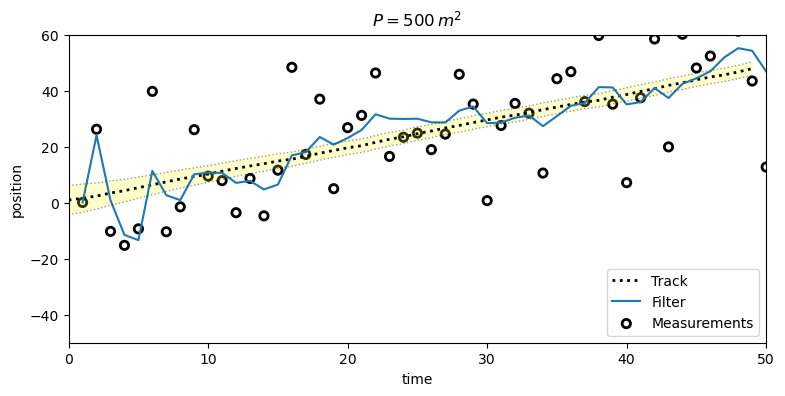

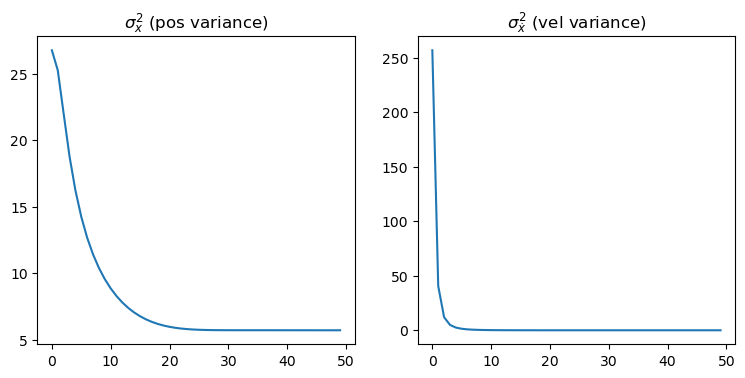

In [46]:
import lean.kf_book.mkf_internal as mkf_internal

var = 27.5
data = mkf_internal.zs_var_275()
run(track=trk, zs=zs, R=var, Q=.02, P=500., plot_P=True, 
    title='$P=500\, m^2$');

查看输出，我们看到滤波器输出在开始时有一个非常大的峰值。我们设置 $\text{P}=500\, \mathbf{I}_2$ (这是一个 2x2 对角矩阵的简写符号，对角线元素为500)。我们现在有足够的信息来理解这意味着什么，以及卡尔曼滤波器如何处理它。 左上角的 500 对应 $\sigma^2_x$; 我们说 `x` 的标准差是 $\sqrt{500}$, 或大约 22.36 m. 大约 99% 的样本发生在 $3\sigma$, 因此 $\sigma^2_x=500$ 告诉卡尔曼滤波器， 预测(先验)可能高达 67 米的误差. 这是一个很大的误差, 所以当测量峰值时，卡尔曼滤波器不信任自己的估计，并疯狂地跳跃试图合并测量结果。 然后, 随机滤波器的进化(发展) $\mathbf P$ 快速收敛到更为实际的值。

让我们看看这背后的数学。卡尔曼增益的方程为：

$$\mathbf K = \mathbf{\bar P} \mathbf H^\mathsf T\mathbf{S}^{-1} \approx \frac{\mathbf{\bar P}\mathbf H^\mathsf T}{\mathbf{S}} 
\approx \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T
$$


它是预测与测量的不确定性的比率。这里预测的不确定性的比例很大, 所以 $\mathbf K$ 很大 (如果是标量，则接近于1)。 $\mathbf K$ 乘以残差 $\textbf{y} = \mathbf z - \mathbf{H \bar x}$, 它是测量减去预测, 所以很大的 $\mathbf K$ 有利于测量。 因此，如果 $\mathbf P$ 相对于传感器的不确定性 $\mathbf R$ 更大，滤波器估计的大部分将会来自于测量值。

现在，让我们看看较小的初始值的影响，其中 $\mathbf P = 1.0\, \mathbf{I}_2$。

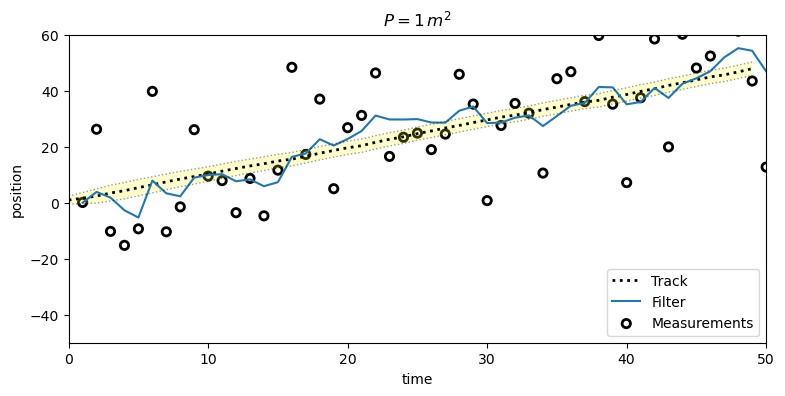

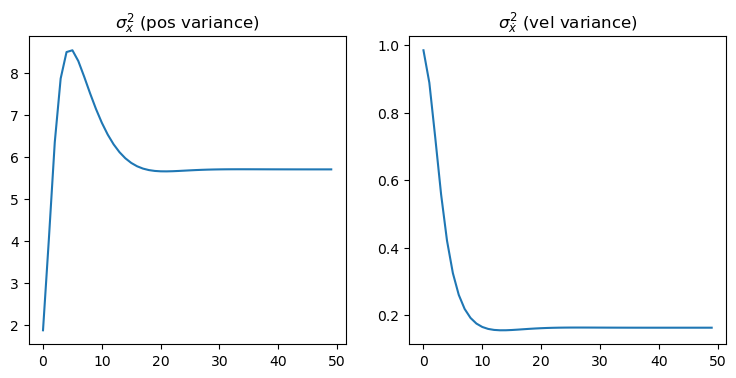

In [47]:
run(track=trk, zs=zs, R=var, Q=.02, P=1., plot_P=True, 
    title='$P=1\, m^2$');

乍一看，这看起来不错。该情节没有前一个情节的峰值;滤波器开始跟踪测量值，并且不需要任何时间来建立信号。但是，如果我们查看 P 的图，您可以看到位置方差有一个初始峰值，并且它从未真正收敛。糟糕的设计会导致收敛时间长，结果欠佳。

因此，尽管滤波器跟踪非常接近实际信号，但我们不能得出结论，使用小 $\mathbf P$ 是一种“魔法”。是的，这将避免卡尔曼滤波器花费时间来准确跟踪信号，但是如果我们真的不确定初始测量结果，这可能会导致滤波器产生非常糟糕的结果。如果我们正在跟踪一个有生命的物体，在我们开始跟踪它之前，我们可能非常不确定它在哪里。另一方面，如果我们过滤温度计的输出，我们对第一次测量和第 1000 次测量一样确定。为了使卡尔曼滤波器表现良好，您必须设置 𝐏
 到真正反映您对数据的了解的值。

让我们看看一个糟糕的初始估计值和非常小的 $\mathbf P$ 会产生什么样的结果。 我们将初始位置估计设置为 x = 100 m (而狗的实际位置是在 0m), 但是设置 `P=1` m$^2$。 这显然是一个不准确的 $\mathbf P$，因为位置估计值与实际偏离了 100 m。 但是，我们却告诉滤波器 $3\sigma$ 误差是 3 m。

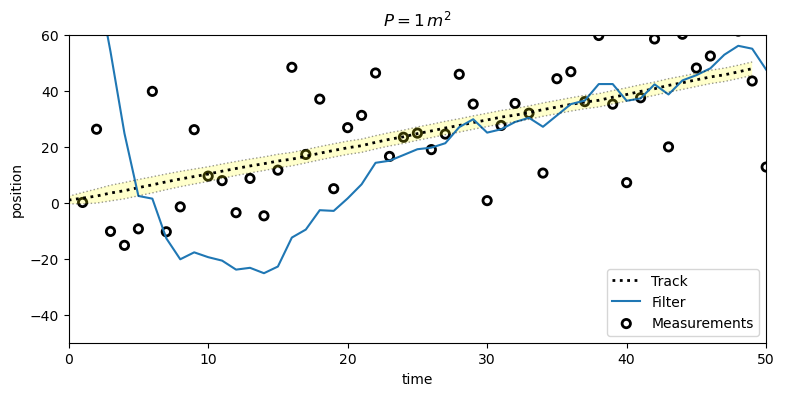

In [48]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=1., x0=x,
    plot_P=False, title='$P=1\, m^2$');

我们可以看到最初的估计很糟糕，滤波器需要很长时间才能开始收敛到信号上。这是因为我们告诉卡尔曼滤波器，我们坚信我们最初估计的100米，并且这种信念是不正确的。

现在, 让我们为 `P` 提供一个合理的值，看看它们的差异。

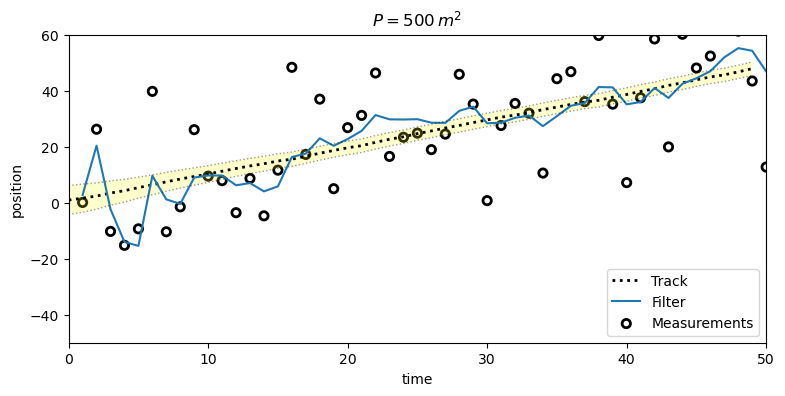

In [49]:
x = np.array([100., 0.])
run(track=trk, zs=zs, R=var, Q=.02, P=500., x0=x,
   plot_P=False, title='$P=500\, m^2$');

在这种情况下，卡尔曼滤波器对初始状态非常不确定，因此它收敛到信号上的速度要快得多。它仅在 5 到 6 个时代后就产生了良好的输出。根据我们迄今为止开发的理论，这几乎是我们所能做的最好的了。但是，这种情况有点人为;如果我们在开始跟踪时不知道对象在哪里，我们不会将过滤器初始化为某个任意值，例如 0 m 或 100 m。我将在下面的过滤器初始化部分中解决此问题。

让我们为我们的狗做另一个卡尔曼滤波器，这次将协方差椭圆绘制在与位置相同的图上。

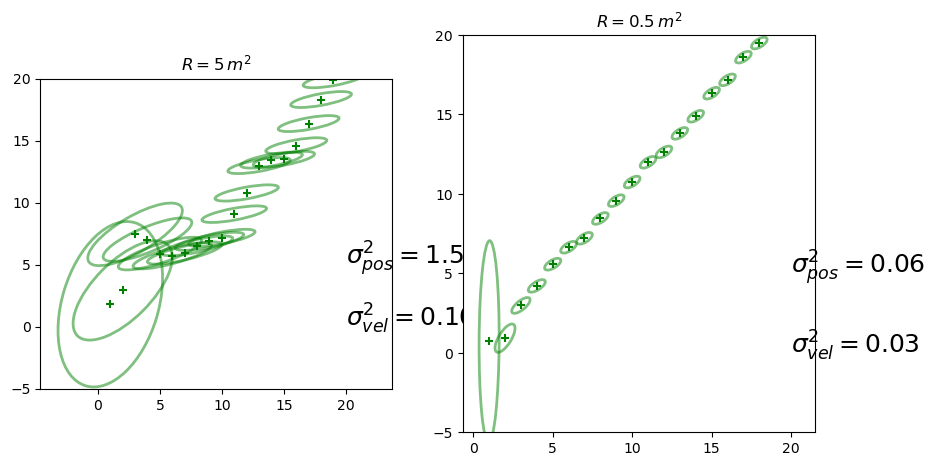

In [50]:
from lean.kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=0, P=20., title=''):    
    track, zs = compute_dog_data(R, Q, count)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

plt.figure(figsize=(10,6))
plt.subplot(121)
plot_covariances(R=5, Q=.02, count=20, title='$R = 5\, m^2$')
plt.subplot(122)
plot_covariances(R=.1, Q=.02, count=20, title='$R = 0.5\, m^2$')

如果您在 Jupyter notebook 或 Web 上查看此内容，下面是过滤器滤波的动画。我已经调整了过滤器参数，以便很容易看到 𝐏 随滤波过程的变化。

<img src='lean/animations/multivariate_track1.gif'>

这些的输出有点混乱，但您应该能够看到正在发生的事情。在这两个图中，我们绘制了每个点的协方差矩阵。我们从协方差 $\mathbf P=(\begin{smallmatrix}20&0\\0&20\end{smallmatrix})$ 开始，这意味着我们最初的信念存在很多不确定性。在我们收到第一次测量值后，卡尔曼滤波器更新了这种信念，因此方差不再那么大。在上面的图中，第一个椭圆（最左侧的椭圆）应该是一个略微压扁的椭圆。当滤波器继续处理测量值时，协方差椭圆会迅速改变形状，直到它稳定下来，成为一个向运动方向倾斜的狭长椭圆。

想一想它的物理意义是什么？椭圆的 x 轴表示位置的不确定性，y 轴表示速度的不确定性。因此，一个高而窄(瘦高，h/w 大于1)的椭圆意味着我们对速度比位置更不确定。相反，宽而低(矮胖)的椭圆在位置上表现出高不确定性，在速度上表现出低不确定性。最后，倾斜量显示两个变量之间的相关性量。最后，倾斜量显示两个变量之间的相关性量。

第一幅图, 设置 $R=5 m^2$, 最后产生一个矮胖的椭圆. 如果不清楚，我已经在右下角打印出了最后一个椭圆的方差。

相比之下, 第二幅图, 设置 `R=0.5` $m^2$, 产生的最后一个瘦高的椭圆。第二个图中的椭圆都比第一个图中的椭圆小得多。 这是有道理的，因为一个小的 $\small\mathbf R$ 在我们测量中意味着少量的噪声。 小噪音意味着准确的预测，因此对我们的立场有坚定的信念。

### **问题：解释椭圆的差异**

为什么 $\mathbf R=5 m^2$ 的椭圆比 $\mathbf R=0.5 m^2$ 的椭圆更倾向于水平？ 提示: 考虑这些椭圆在物理上的含义, 而不是从数学角度考虑。 如果你不确定答案,改变 $\mathbf R$ 为真正的大数字和小数字，例如 100 $m^2$ 和 0.1 $m^2$, 观察变化, 并思考这意味着什么？

#### **解答**

x 轴表示位置，y 轴表示速度。垂直或接近垂直的椭圆表示位置和速度之间没有相关性，对角线的椭圆表示存在很多相关性。这样说，结果听起来不太像。椭圆的倾斜度会发生变化，但相关性不应随时间而变化。但这是对滤波器输出的度量，而不是对实际物理世界的描述。当 $\mathbf R$ 非常大时， 我们告诉滤波器测量中有很多噪声。 在这种情况下，卡尔曼增益 $\mathbf K$ 设置为有利于预测而不是测量，并且预测来自速度状态变量。 因此 $x$ 和 $\dot x$ 之间存在很大的相关性。 相反地, 如果 $\mathbf R$ 非常小, 我们告诉过滤器测量值非常可信， 并且 $\mathbf K$ 设置为有利于测量值而不是预测值。如果测量值接近完美，为什么筛选器要使用预测？如果过滤器没有从预测中使用太多，则报告的相关性将很少。

**这是需要理解的关键点**！卡尔曼滤波器是现实世界系统的数学模型。很少相关的报告并不意味着物理系统中没有相关性，只是数学模型中没有线性相关性。这是一份关于模型合并了多少测量与预测的报告。

让我们用一个非常大的测量误差， 我们将设置 $\mathbf R=200\, m^2$。在看之前，想象一下图像是什么样子？

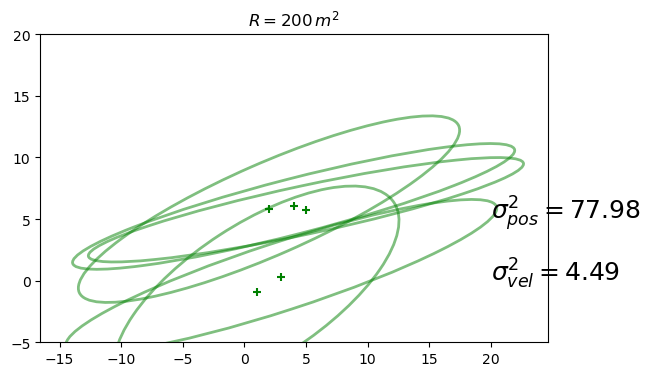

In [54]:
plot_covariances(R=200, Q=.2, count=5, title='$R = 200\, m^2$')

我希望结果是你所期望的。椭圆很快变得非常宽，不是很高。之所以这样做，是因为相比于测量值卡尔曼滤波器主要使用预测产生过滤结果。我们还可以看到滤波器输出如何缓慢地获取轨迹。卡尔曼滤波器假设测量值非常嘈杂，因此更新其 $\dot x$ 的估计值非常慢。

继续查看这些图，直到您掌握了如何解释协方差矩阵 $\mathbf P$。 当你使用 $9{\times}9$ 矩阵时，它可能看起来势不可挡 - 有81个数字需要解释。只需将其分解 - 对角线包含每个状态变量的方差, 所有非对角线元素都是两个方差和一个比例因子 $p$ 的乘积。 你不可能在屏幕上绘制 $9{\times}9$ 矩阵，所以你必须在这个简单的二维情况下发展你的直觉和理解力。

>绘制协方差椭圆时，请确保在代码中始终使用 ax.set_aspect('equal') 或者 plt.axis('equal')(前者允许您设置 xlim 和 ylim 值)。如果轴使用不同的比例，则椭圆的绘制将失真。例如，椭圆可能被绘制为高大于宽，但实际上可能比高宽。

### **滤波器初始化**

有许多用于初始化筛选器的方案。以下方法在大多数情况下表现良好。在此方案中，在获得第一个测量值 $\mathbf z_0$ 之前，不会初始化过滤器。由此，你可以计算 $\mathbf x$ 的初始值，其中 $\mathbf x_0 = \mathbf z_0$。如果  $\mathbf z$ 的大小、类型和单位与 $\mathbf x$ 不同, 通常情况下, 我们可以采用测量函数去转换。

我们知道

$$\mathbf z = \mathbf{Hx}$$

因此,

$$\begin{aligned}
\mathbf H^{-1}\mathbf{Hx} &= \mathbf H^{-1}\mathbf z \\
\mathbf x &= \mathbf H^{-1}\mathbf z\end{aligned}$$

矩阵的逆要求一个方阵, 但是 $\mathbf H$ 很少是方阵。 SciPy 将使用 `scipy.linalg.pinv` 计算矩阵的摩尔－彭若斯广义逆，因此您的代码可能如下所示：

In [61]:
from scipy.linalg import pinv

H = np.array([[1, 0.]])
z0 = 3.2

x = np.dot(pinv(H), z0)
print('初始值x = ', x)
print('H的广义逆矩阵: ', pinv(H))

初始值x =  [[3.2]
 [0. ]]
H的广义逆矩阵:  [[1.]
 [0.]]


问题域的专业知识可能会引导您进行不同的计算，但这是一种方法。例如，如果状态包括速度，则可以对位置进行前两个测量，计算差值，并将其用作初始速度。

现在我们需要计算 $\mathbf P$的值。 这将因问题而异, 但是，通常你将使用和测量误差 $\mathbf R$ 一样的值, 并且对其余的元素使用它的最大值。也许这并不清楚。 在本章中，我们一直使用位置和速度作为状态来跟踪和对象, 并且测量的是位置。在这种情况下，我们将初始化 $\mathbf P$ 为：

$$\mathbf P = \begin{bmatrix}\mathbf R_0 & 0 \\0 & vel_{max}^2\end{bmatrix}$$

$\mathbf P$ 的对角线包含了每个状态变量的方差，因此我们使用合理值去填充它。$\mathbf R$ 是位置的合理方差, 并且速度最大值的平方是速度的合理方差。它是平方的，因为方差是平方的: $\sigma^2$。

您确实需要了解您正在使用的域，并根据最佳可用信息初始化过滤器。例如，假设我们试图在赛马中跟踪马匹。初始测量可能非常糟糕，它是远离提供的起始门位置。我们知道马必须从起跑门开始，将滤波器初始化为初始测量值将导致次优结果。在这种情况下，我们希望始终使用马的起始门位置初始化卡尔曼滤波器。

### **批处理**

卡尔曼滤波器被设计为递归算法 - 当新的测量值出现时，我们会立即创建一个新的估计值。但是，我们想要过滤一组已经收集的数据是很常见的。卡尔曼滤波器可以在批处理模式下运行，其中所有测量值一次被过滤。我们已在 `KalmanFilter.batch_filter()` 中实现了这一点。在内部，该函数所做的只是遍历测量值，并在数组中收集结果状态和协方差估计值。它简化了您的逻辑，并方便地将所有输出收集到数组中。我经常使用这个函数，但等到本章末尾，所以你会非常熟悉你必须循环运行 预测/更新。

首先将测量值收集到数组或列表中。也许它在 CSV 文件中：

```python
zs = read_altitude_from_csv('altitude_data.csv')
```

或者，也许您将使用生成器生成它：

```python
zs = [some_func(i) for i in range(1000)]
```

然后调用`batch_filter()`方法。

```python
Xs, Ps, Xs_prior, Ps_prior = kfilter.batch_filter(zs)
```

该函数获取测量值列表，对其进行过滤，并返回状态估计值 (Xs), 协方差矩阵 (Ps), 和相同值的先验值  (Xs_prior, Ps_prior)的数组。

这是一个完整的示例。


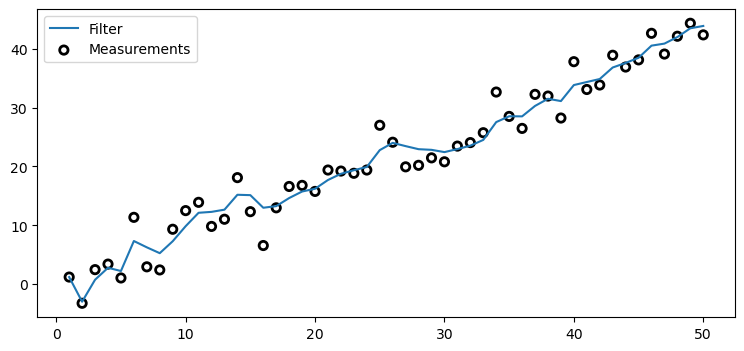

In [62]:
count = 50
track, zs = compute_dog_data(10, .2, count)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
xs, _, _, _ = f.batch_filter(zs)

book_plots.plot_measurements(range(1, count + 1), zs)
book_plots.plot_filter(range(1, count + 1), xs[:, 0])
plt.legend(loc='best');

批处理过滤器采用`filterpy.common.Saver`可选对象。如果提供，过滤器的所有属性也将保存。如果要检查状态和协方差以外的值，这将非常有用。在这里，我绘制残差，看看它是否看起来像以 0 为中心的噪声。这是一个快速的目视检查，以查看过滤器是否设计良好。如果从零漂移，或者看起来不像噪声，则滤波器设计不佳和/或过程不是高斯的。我们将在后面的章节中详细讨论这一点。现在，将此视为`Saver`类的演示。

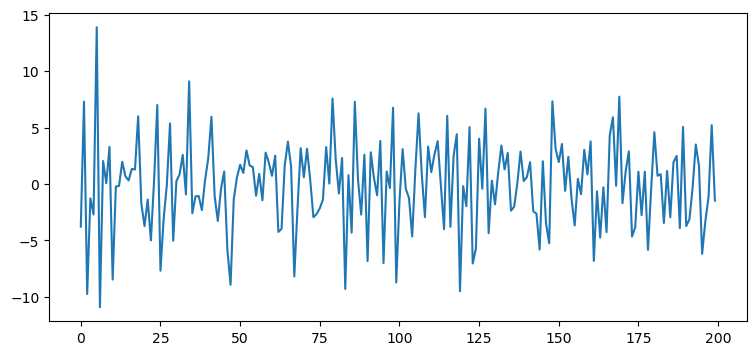

In [63]:
track, zs = compute_dog_data(10, .2, 200)
P = np.diag([500., 49.])
f = pos_vel_filter(x=(0., 0.), R=3., Q=.02, P=P)
s = Saver(f)
xs, _, _, _ = f.batch_filter(zs, saver=s)
s.to_array()
plt.plot(s.y);

### **平滑结果**